In [92]:
# !pip install pingouin

In [93]:
# !pip install scikit-posthocs

In [94]:
# !pip install yellowbrick

In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import pearsonr, bartlett, levene, wilcoxon, mannwhitneyu, ttest_ind, f_oneway, kruskal
from scipy.stats import shapiro, anderson, kstest, normaltest, jarque_bera
from scipy.stats import chi2_contingency, chisquare
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [406]:
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [407]:
df = pd.read_csv(r'C:\Users\User\Desktop\DigitalHana_Project2\Data\HanaCard_Data.csv', encoding = 'cp949')

In [408]:
df2 = df.copy()

In [409]:
# 활용할 수 없는 Column들을 삭제
df2.drop(columns = ['남녀구분코드', '연령', '거주시도명', '거주시군구명', '직장시도명', '직장시군구명', '납부_렌탈료이용금액', '컨택건수_CA_TM_B0M', '컨택건수_CA_EM_B0M', '컨택건수_리볼빙_EM_B0M', '컨택건수_리볼빙_청구서_B0M', '컨택건수_카드론_인터넷_B0M', '컨택건수_CA_인터넷_B0M', '컨택건수_리볼빙_인터넷_B0M', '컨택건수_CA_EM_R6M', '컨택건수_리볼빙_EM_R6M', '컨택건수_리볼빙_청구서_R6M', '컨택건수_카드론_인터넷_R6M', '컨택건수_CA_인터넷_R6M', '컨택건수_리볼빙_인터넷_R6M'], inplace = True)

In [410]:
d = {
    '21.Active_연속' : 0,
    '22.Active_간헐' : 1,
    '34.휴면_9M+' : 2,
    '32.휴면_6M-' : 2,
    '33.휴면_9M-' : 2,
    '31.휴면_3M' : 2
}
df2['고객구분'] = df2['고객구분'].map(d)

In [411]:
df2['Recency'] = (df[['이용후경과월_신용','이용후경과월_체크', '이용후경과월_카드론']]).min(axis= 1)

In [412]:
df2['Recency'].value_counts().sort_index()

0     243637
1       8549
2       5339
3       4252
4       3121
5       2768
6       2468
7       2273
8       1903
9       1721
10      1644
11      1539
12     20786
Name: Recency, dtype: int64

In [413]:
df2['Recency'].value_counts().sort_index().values

array([243637,   8549,   5339,   4252,   3121,   2768,   2468,   2273,
         1903,   1721,   1644,   1539,  20786], dtype=int64)

In [414]:
import itertools
val = [243637,   8549,   5339,   4252,   3121,   2768,   2468,   2273, 1903,   1721,   1644,   1539,  20786]
res = []

for case in filter(lambda x : sum(x) == 13, itertools.product(range(1, 7), repeat = 8)):
    res.append((case, pd.Series([sum(val[:case[0]]), sum(val[case[0]:sum(case[:1])]), sum(val[sum(case[:1]):sum(case[:2])]), sum(val[sum(case[:2]):sum(case[:3])]), sum(val[sum(case[:3]):sum(case[:4])]), sum(val[sum(case[:4]):sum(case[:5])]), sum(val[sum(case[:5]):sum(case[:6])]), sum(val[sum(case[:6]):])]).std()))

sorted(res, key = lambda x : x[1])[:10]

[((1, 1, 1, 2, 3, 3, 1, 1), 83535.69104623143),
 ((1, 1, 1, 2, 2, 4, 1, 1), 83535.81543437351),
 ((1, 1, 1, 1, 3, 4, 1, 1), 83541.06718939409),
 ((1, 1, 2, 2, 2, 3, 1, 1), 83544.15026285716),
 ((1, 1, 1, 1, 2, 5, 1, 1), 83548.03889465543),
 ((1, 1, 1, 3, 2, 3, 1, 1), 83548.14907926702),
 ((1, 1, 2, 2, 3, 2, 1, 1), 83548.62772062747),
 ((1, 1, 1, 2, 4, 2, 1, 1), 83549.17612144016),
 ((1, 1, 2, 1, 3, 3, 1, 1), 83551.8176445868),
 ((1, 1, 2, 1, 2, 4, 1, 1), 83551.94200872038)]

In [415]:
df2['Recency_8'] = df2['Recency'].map(lambda x : dict(zip(range(13), [8, 7, 6, 5, 5, 4, 4, 4, 3, 3, 3, 2, 1]))[x])

In [416]:
df2['Frequency'] = df2['이용건수_신용_R12M'] + df2['이용건수_체크_R12M'] + df2['이용건수_카드론_R12M']

In [417]:
df2['Frequency_8'] = pd.cut(df2['Frequency'], bins = [df2['Frequency'].quantile(0), df2['Frequency'].quantile(0.125), df2['Frequency'].quantile(0.25), df2['Frequency'].quantile(0.375), df2['Frequency'].quantile(0.5), df2['Frequency'].quantile(0.625), df2['Frequency'].quantile(0.75), df2['Frequency'].quantile(0.875), df2['Frequency'].quantile(1)], labels = range(1, 9), include_lowest = True).astype(np.int64)

In [418]:
df2['Monetary'] = df2['이용금액_신용_R12M'] + df2['이용금액_체크_R12M'] + df2['이용금액_카드론_R12M'] + df2['이용금액_업종기준']

In [419]:
df2['Monetary_8'] = pd.cut(df2['Monetary'], bins = [df2['Monetary'].quantile(0), df2['Monetary'].quantile(0.125), df2['Monetary'].quantile(0.25), df2['Monetary'].quantile(0.375), df2['Monetary'].quantile(0.5), df2['Monetary'].quantile(0.625), df2['Monetary'].quantile(0.75), df2['Monetary'].quantile(0.875), df2['Monetary'].quantile(1)], labels = range(1, 9), include_lowest = True).astype(np.int64)

# RFM 8개 값 분류

In [420]:
scaler = MinMaxScaler()
df2['Recency_s'] = scaler.fit_transform(df2[['Recency']])
df2['Frequency_s'] = scaler.fit_transform(df2[['Frequency']])
df2['Monetary_s'] = scaler.fit_transform(df2[['Monetary']])

KElbowVisualizer(ax=<Axes: >, distance_metric='euclidean',
                 estimator=KMeans(algorithm='lloyd', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=9,
                                  n_init='warn', random_state=None, tol=0.0001,
                                  verbose=0),
                 k=(1, 10), locate_elbow=True, metric='distortion',
                 timings=True)

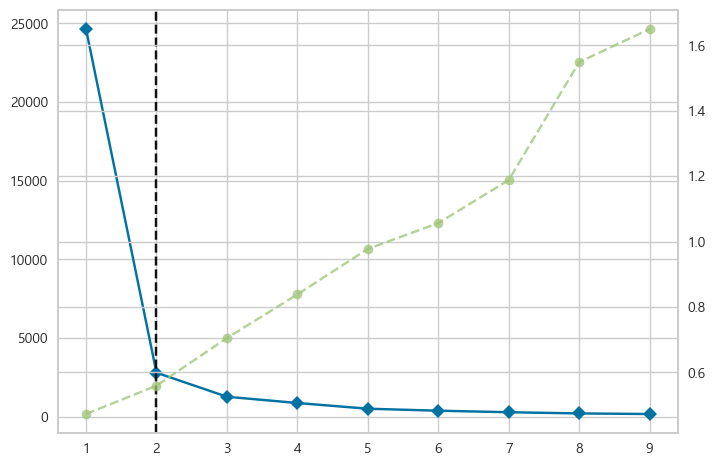

In [421]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df2[['Recency_s','Frequency_s','Monetary_s']])
# k = 2

In [422]:
# KMeans 모델 생성 (k=2)
kmeans = KMeans(n_clusters=2)
# 모델 학습 및 예측
labels = kmeans.fit_predict(df2[['Recency_s','Frequency_s','Monetary_s']])

In [423]:
df2['labels_k'] = labels

In [424]:
# CV = k개 그룹에 대한 각 R,F,M의 표준편차 / 평균
cv_k = df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('std') / df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('mean')
cv_k

,Recency_s,Frequency_s,Monetary_s
labels_k,,,
0,3.707733,1.040649,1.242323
1,0.195777,1.055173,0.395543


In [425]:
res = cv_k.min(axis = 0) / cv_k.sum()
res

Recency_s      0.050154
Frequency_s    0.496535
Monetary_s     0.241499
dtype: float64

In [426]:
# 가중치
w1, w2, w3 = (res / res.sum())
print(w1, w2, w3)

0.0636321049561043 0.629970431576547 0.30639746346734875


In [427]:
df2['RFM_Score'] = ((w1 * df2['Recency_8'] + w2 * df2['Frequency_8'] + w3 * df2['Monetary_8']) / 8) * 100

In [428]:
df2['RFM_Class'] = pd.cut(df2['RFM_Score'], bins = [df2['RFM_Score'].quantile(0), df2['RFM_Score'].quantile(0.125), df2['RFM_Score'].quantile(0.25), df2['RFM_Score'].quantile(0.375), df2['RFM_Score'].quantile(0.5), df2['RFM_Score'].quantile(0.625), df2['RFM_Score'].quantile(0.75), df2['RFM_Score'].quantile(0.875), df2['RFM_Score'].quantile(1)], labels = ['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], include_lowest = True).astype(np.dtype('O'))
df2['RFM_Class'].value_counts().sort_index(key = lambda x : x.map(lambda y : dict(zip(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], range(8, 0, -1)))[y]))

VIP고객      33888
충성고객       35958
잠재VIP고객    41408
잠재충성고객     37134
놓치면안될고객    32255
관심필요고객     37092
이탈우려고객     44743
겨울잠고객      37522
Name: RFM_Class, dtype: int64

In [429]:
df2.groupby(by = ['RFM_Class'])[['Recency', 'Frequency', 'Monetary']].agg('median').sort_index(key = lambda x : x.map(lambda y : dict(zip(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], range(8, 0, -1)))[y]))

,Recency,Frequency,Monetary
RFM_Class,,,
VIP고객,0.0,832.0,24057959.0
충성고객,0.0,459.0,18081942.5
잠재VIP고객,0.0,296.0,10628446.0
잠재충성고객,0.0,186.0,6953471.0
놓치면안될고객,0.0,105.0,6323250.0
관심필요고객,0.0,56.0,2930139.5
이탈우려고객,0.0,17.0,640360.0
겨울잠고객,12.0,0.0,0.0


In [430]:
# 연속 : VIP고객, 충성고객, 잠재VIP고객
# 간헐 : 잠재충성고객, 놓치면안될고객
# 휴면 : 겨울잠고객,이탈우려고객, 관심필요고객

In [431]:
df2['고객구분_New'] = '임시'
df2.loc[df2['RFM_Class'].isin(['VIP고객', '충성고객', '잠재VIP고객']), '고객구분_New'] = '연속'
df2.loc[df2['RFM_Class'].isin(['잠재충성고객', '놓치면안될고객']), '고객구분_New'] = '간헐'
df2.loc[df2['RFM_Class'].isin(['관심필요고객', '이탈우려고객', '겨울잠고객']), '고객구분_New'] = '휴면'

In [432]:
df2['고객구분_New'].value_counts()

휴면    119357
연속    111254
간헐     69389
Name: 고객구분_New, dtype: int64

In [433]:
for rfm, customer_group in sorted(df2.groupby(by = ['RFM_Class'])[['고객구분']], key = lambda x : dict(zip(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], range(8, 0, -1)))[x[0]]):
    print(rfm)
    print(customer_group['고객구분'].value_counts())
    print()

VIP고객
0    33121
1      540
2      227
Name: 고객구분, dtype: int64

충성고객
0    34469
1     1038
2      451
Name: 고객구분, dtype: int64

잠재VIP고객
0    38619
1     1805
2      984
Name: 고객구분, dtype: int64

잠재충성고객
0    33689
1     2129
2     1316
Name: 고객구분, dtype: int64

놓치면안될고객
0    26534
1     3544
2     2177
Name: 고객구분, dtype: int64

관심필요고객
0    26307
1     6563
2     4222
Name: 고객구분, dtype: int64

이탈우려고객
0    28217
1     9055
2     7471
Name: 고객구분, dtype: int64

겨울잠고객
2    31254
1     4361
0     1907
Name: 고객구분, dtype: int64



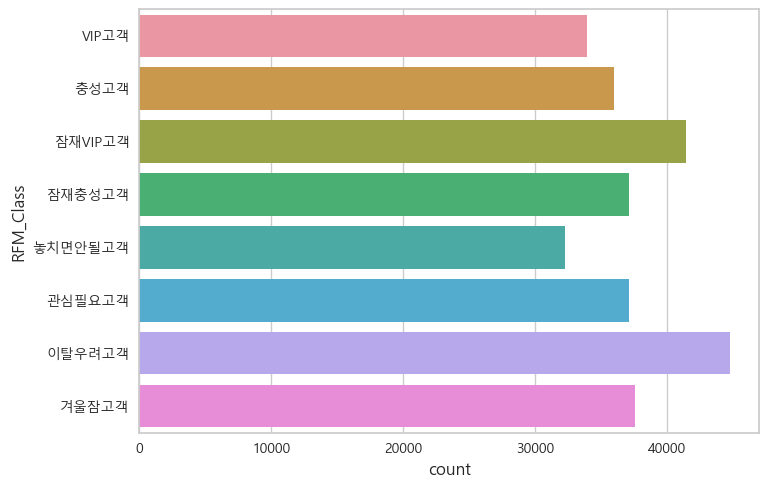

In [434]:
sns.countplot(y = 'RFM_Class', data = df2, orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']))
plt.show()

In [435]:
# RFM_Class 그룹에 따른 R, F, M들의 평균값/중위값 차이가 있는지 분산분석
for column in ['Recency', 'Frequency', 'Monetary']:
  normally = []
  for cla in df2['RFM_Class'].unique():
    # 1. 정규성 검정
    # shapiro나 kolmogorov-smirnov 같은 검정방법은 데이터의 갯수에 따라 달라지므로 데이터 갯수에 상관없이 하기 위해 normaltest로 검정
    cla_tv, cla_pv = normaltest(df2.loc[df2['RFM_Class'] == cla, column])
    if cla_pv >= 0.05:
      normally.append(True)
    else:
      normally.append(False)

  # 정규성인지 아닌지에 따라 등분산분석 할지 정하기
  if all(normally):
    # 2. 등분산분석
    bartlett_tv, bartlett_pv = bartlett(*[df2.loc[df2['RFM_Class'] == cla, column] for cla in df2['RFM_Class'].unique()])
    # 등분산이므로 F검정으로 일원분산분석
    if bartlett_pv >= 0.05:
      f_oneway_tv, f_oneway_pv = f_oneway(*[df2.loc[df2['RFM_Class'] == cla, column] for cla in df2['RFM_Class'].unique()])
      if f_oneway_pv < 0.05:
        print(f'column : {column},     f_oneway : {f_oneway_pv}')
    # 등분산이 아니므로 Welch_Anova로 일원분산분석
    else:
      welch_anova_tv, welch_anova_pv = pg.welch_anova(dv = column, between = 'RFM_Class', data = df2)
      if welch_anova_pv < 0.05:
        print(f'column : {column},     welch_anova_pv : {welch_anova_pv}')
  # 정규성을 만족하지 않으므로 Kruskal-Wallis H-test로 일원분산분석
  else:
    kruskal_tv, kruskal_pv = kruskal(*[df2.loc[df2['RFM_Class'] == cla, column] for cla in df2['RFM_Class'].unique()])
    if kruskal_pv < 0.05:
      print(f'column : {column},     kruskal_pv : {kruskal_pv}')

column : Recency,     kruskal_pv : 0.0
column : Frequency,     kruskal_pv : 0.0
column : Monetary,     kruskal_pv : 0.0


In [436]:
df2.groupby(by = ['RFM_Class'])[['Recency', 'Frequency', 'Monetary']].agg('median').sort_index(key = lambda x : x.map(lambda y : dict(zip(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], range(8, 0, -1)))[y]))

,Recency,Frequency,Monetary
RFM_Class,,,
VIP고객,0.0,832.0,24057959.0
충성고객,0.0,459.0,18081942.5
잠재VIP고객,0.0,296.0,10628446.0
잠재충성고객,0.0,186.0,6953471.0
놓치면안될고객,0.0,105.0,6323250.0
관심필요고객,0.0,56.0,2930139.5
이탈우려고객,0.0,17.0,640360.0
겨울잠고객,12.0,0.0,0.0


In [403]:
df2.groupby(by = ['고객구분_New'])[['이용후경과월_신용']].agg('mean')

,이용후경과월_신용
고객구분_New,
간헐,0.375621
연속,0.121678
휴면,3.540714


In [445]:
df2.loc[(df2['고객구분'] == 0), '이용후경과월_신용'].describe()

count    222863.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: 이용후경과월_신용, dtype: float64

In [447]:
df2.loc[df2['고객구분'] == 0, '이용후경과월_신용'].describe()

count    222863.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: 이용후경과월_신용, dtype: float64

In [448]:
df2.loc[(df2['고객구분'] == 1), '이용후경과월_신용'].describe()

count    29035.000000
mean         0.686620
std          0.772797
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: 이용후경과월_신용, dtype: float64

In [449]:
df2.loc[(df2['고객구분'] == 2), '이용후경과월_신용'].describe()

count    48102.000000
mean         9.194503
std          3.412185
min          3.000000
25%          6.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: 이용후경과월_신용, dtype: float64

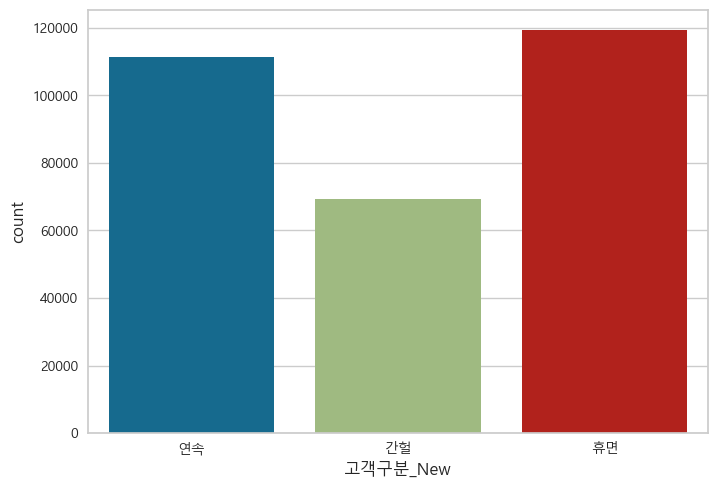

In [400]:
sns.countplot(x = '고객구분_New', data = df2, order = ['연속', '간헐', '휴면'])
plt.show()

In [401]:
df2['고객구분_New'].value_counts()

휴면    119357
연속    111253
간헐     69389
Name: 고객구분_New, dtype: int64

In [397]:
for cla in sorted(df2['RFM_Class'].unique(), key = lambda x : dict(zip(['겨울잠고객', '이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], range(8, 0, -1)))[x]):
    print(cla, f"min : {df2.loc[df2['RFM_Class'] == cla, 'RFM_Score'].min()}, max : {df2.loc[df2['RFM_Class'] == cla, 'RFM_Score'].max()}, mean : {df2.loc[df2['RFM_Class'] == cla, 'RFM_Score'].mean()}")

VIP고객 min : 92.34006341331629, max : 100.0, mean : 97.56606426579343
충성고객 min : 80.85015853329071, max : 92.12536960529316, mean : 87.57475579836927
잠재VIP고객 min : 69.145559845242, max : 80.63546472526758, mean : 76.43582255866953
잠재충성고객 min : 60.90919737609739, max : 68.93086603721889, mean : 65.34587274279984
놓치면안될고객 min : 49.41929249607181, max : 60.841541834488936, mean : 55.8302891278189
관심필요고객 min : 37.714693808023114, max : 49.35163695446336, mean : 44.9196762186537
이탈우려고객 min : 25.580707503928185, max : 37.64703826641466, mean : 31.465765454589437
겨울잠고객 min : 12.5, max : 25.147038266414658, mean : 15.05975908960085


In [240]:
# 고객구분_New 그룹에 따른 int64 또는 float64 Column들의 평균값/중위값 차이가 있는지 분산분석
Different_Columns = []
NonDifferent_Columns = []

for column in df2.columns[(df2.columns != '회원번호') & ((df2.dtypes == np.int64) | (df2.dtypes == np.float64))]:
  normally = []
  for cla in df2['고객구분_New'].unique():
    # 1. 정규성 검정
    # shapiro나 kolmogorov-smirnov 같은 검정방법은 데이터의 갯수에 따라 달라지므로 데이터 갯수에 상관없이 하기 위해 normaltest로 검정
    cla_tv, cla_pv = normaltest(df2.loc[df2['고객구분_New'] == cla, column])
    if cla_pv >= 0.05:
      normally.append(True)
    else:
      normally.append(False)

  # 정규성인지 아닌지에 따라 등분산분석 할지 정하기
  if all(normally):
    # 2. 등분산분석
    bartlett_tv, bartlett_pv = bartlett(*[df2.loc[df2['고객구분_New'] == cla, column] for cla in df2['고객구분_New'].unique()])
    # 등분산이므로 F검정으로 일원분산분석
    if bartlett_pv >= 0.05:
      f_oneway_tv, f_oneway_pv = f_oneway(*[df2.loc[df2['고객구분_New'] == cla, column] for cla in df2['고객구분_New'].unique()])
      if f_oneway_pv < 0.05:
        print(f'column : {column},     f_oneway : {f_oneway_pv}')
        Different_Columns.append(column)
      else:
        NonDifferent_Columns.append(column)
    # 등분산이 아니므로 Welch_Anova로 일원분산분석
    else:
      welch_anova_tv, welch_anova_pv = pg.welch_anova(dv = column, between = '고객구분_New', data = df2)
      if welch_anova_pv < 0.05:
        print(f'column : {column},     welch_anova_pv : {welch_anova_pv}')
        Different_Columns.append(column)
      else:
        NonDifferent_Columns.append(column)
  # 정규성을 만족하지 않으므로 Kruskal-Wallis H-test로 일원분산분석
  else:
    kruskal_tv, kruskal_pv = kruskal(*[df2.loc[df2['고객구분_New'] == cla, column] for cla in df2['고객구분_New'].unique()])
    if kruskal_pv < 0.05:
      print(f'column : {column},     kruskal_pv : {kruskal_pv}')
      Different_Columns.append(column)
    else:
      NonDifferent_Columns.append(column)

print(Different_Columns)
print(NonDifferent_Columns)

column : 소지여부_신용,     kruskal_pv : 0.0
column : 입회경과개월수_신용,     kruskal_pv : 0.0
column : 탈회여부,     kruskal_pv : 5.374148817184009e-84
column : 회원여부_연체,     kruskal_pv : 4.5608067582684725e-39
column : 수신거부여부_TM,     kruskal_pv : 0.0
column : 수신거부여부_DM,     kruskal_pv : 0.0
column : 수신거부여부_메일,     kruskal_pv : 0.0
column : 수신거부여부_SMS,     kruskal_pv : 4.591168661180841e-49
column : BL여부_R12M,     kruskal_pv : 0.0
column : 탈회횟수_누적,     kruskal_pv : 1.8470625039026443e-119
column : 탈회횟수_발급1년이내,     kruskal_pv : 7.196637318898511e-19
column : 마케팅동의여부,     kruskal_pv : 1.3413823105802966e-125
column : 유효카드수_신용체크,     kruskal_pv : 0.0
column : 유효카드수_신용,     kruskal_pv : 0.0
column : 유효카드수_체크,     kruskal_pv : 0.0
column : 이용금액_R3M_신용체크,     kruskal_pv : 0.0
column : 이용금액_R3M_신용,     kruskal_pv : 0.0
column : 이용금액_R3M_체크,     kruskal_pv : 0.0
column : _1순위카드ID,     kruskal_pv : 0.0
column : _1순위카드이용금액,     kruskal_pv : 0.0
column : _1순위카드이용건수,     kruskal_pv : 0.0
column : 기본연회비_B0M,     kru

column : 납부_보험료이용금액,     kruskal_pv : 0.0
column : 납부_유선방송이용금액,     kruskal_pv : 1.7734577388696674e-53
column : 납부_건강연금이용금액,     kruskal_pv : 1.9324275437312137e-115
column : 납부_기타이용금액,     kruskal_pv : 0.0
column : 납부_전체이용금액,     kruskal_pv : 0.0
column : 할부건수_3M_R12M,     kruskal_pv : 0.0
column : 할부건수_6M_R12M,     kruskal_pv : 0.0
column : 할부건수_12M_R12M,     kruskal_pv : 0.0
column : RP건수_B0M,     kruskal_pv : 0.0
column : RP금액_B0M,     kruskal_pv : 0.0
column : 증감_RP건수_전월,     kruskal_pv : 2.985214091293267e-24
column : 증감_RP유형건수_전월,     kruskal_pv : 3.3227318478042725e-17
column : 이용개월수_온라인_R6M,     kruskal_pv : 0.0
column : 이용개월수_오프라인_R6M,     kruskal_pv : 0.0
column : 이용건수_오프라인_R6M,     kruskal_pv : 0.0
column : 이용건수_온라인_B0M,     kruskal_pv : 0.0
column : 이용건수_오프라인_B0M,     kruskal_pv : 0.0
column : 이용개월수_페이_온라인_R6M,     kruskal_pv : 0.0
column : 이용개월수_페이_오프라인_R6M,     kruskal_pv : 0.0
column : 이용금액_페이_온라인_R6M,     kruskal_pv : 0.0
column : 이용건수_페이_온라인_R6M,     kruskal_pv : 0.0

In [227]:
df3 = df2[['소지여부_신용', '탈회여부', '회원여부_연체', '수신거부여부_TM', '수신거부여부_DM','수신거부여부_메일', '수신거부여부_SMS', '자격기준', '자격구분상세', '연회비청구구분_B0M', 'BL여부_R12M','마케팅동의여부', '_1순위신용체크구분', 'Life_Stage', '이용금액대', '고객구분', 'RFM_Class']].copy()
df3['소지여부_신용'] = df3['소지여부_신용'].map(lambda x : {0 : '미소지', 1 : '소지'}[x])
df3['탈회여부'] = df3['탈회여부'].map(lambda x : {0 : '유지', 1 : '탈퇴'}[x])
df3['회원여부_연체'] = df3['회원여부_연체'].map(lambda x : {0 : '미연체', 1 : '연체'}[x])
df3['수신거부여부_TM'] = df3['수신거부여부_TM'].map(lambda x : {0 : '승인', 1 : '거부'}[x])
df3['수신거부여부_DM'] = df3['수신거부여부_DM'].map(lambda x : {0 : '승인', 1 : '거부'}[x])
df3['수신거부여부_메일'] = df3['수신거부여부_메일'].map(lambda x : {0 : '승인', 1 : '거부'}[x])
df3['수신거부여부_SMS'] = df3['수신거부여부_SMS'].map(lambda x : {0 : '승인', 1 : '거부'}[x])
df3['BL여부_R12M'] = df3['BL여부_R12M'].map(lambda x : {0 : '미등록', 1 : '등록'}[x])
df3['마케팅동의여부'] = df3['마케팅동의여부'].map(lambda x : {0 : '미동의', 1 : '동의'}[x])
df3['고객구분'] = df3['고객구분'].map(lambda x : {0 : '연속', 1 : '간헐', 2 : '휴면'}[x])

In [237]:
# 고객구분_New과 np.dtype('O') Column들이 서로 독립인지 아닌지 카이제곱 독립성 검정
Different_Columns = []
NonDifferent_Columns = []

for column in ['소지여부_신용', '탈회여부', '회원여부_연체', '수신거부여부_TM', '수신거부여부_DM','수신거부여부_메일', '수신거부여부_SMS', '자격기준', '자격구분상세', '연회비청구구분_B0M', 'BL여부_R12M','마케팅동의여부', '_1순위신용체크구분', 'Life_Stage', '이용금액대', '고객구분', 'RFM_Class']:
    # 카이제곱 독립섬 검정
    chi2_tv, chi2_pv, dof, expect = chi2_contingency(pd.crosstab(df2['고객구분_New'], df3[column]))
    if chi2_pv < 0.05:
        print(f'column : {column},     chi2_pv : {chi2_pv}')
        Different_Columns.append(column)
    else:
        NonDifferent_Columns.append(column)

print(Different_Columns)
print(NonDifferent_Columns)

column : 소지여부_신용,     chi2_pv : 0.0
column : 탈회여부,     chi2_pv : 5.684016079591092e-84
column : 회원여부_연체,     chi2_pv : 4.54851843249192e-39
column : 수신거부여부_TM,     chi2_pv : 0.0
column : 수신거부여부_DM,     chi2_pv : 0.0
column : 수신거부여부_메일,     chi2_pv : 0.0
column : 수신거부여부_SMS,     chi2_pv : 4.718975801359319e-49
column : 자격기준,     chi2_pv : 0.0
column : 자격구분상세,     chi2_pv : 0.0
column : 연회비청구구분_B0M,     chi2_pv : 0.0
column : BL여부_R12M,     chi2_pv : 0.0
column : 마케팅동의여부,     chi2_pv : 1.3776149065568385e-125
column : _1순위신용체크구분,     chi2_pv : 0.0
column : Life_Stage,     chi2_pv : 0.0
column : 이용금액대,     chi2_pv : 0.0
column : 고객구분,     chi2_pv : 0.0
column : RFM_Class,     chi2_pv : 0.0
['소지여부_신용', '탈회여부', '회원여부_연체', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', '자격기준', '자격구분상세', '연회비청구구분_B0M', 'BL여부_R12M', '마케팅동의여부', '_1순위신용체크구분', 'Life_Stage', '이용금액대', '고객구분', 'RFM_Class']
[]


In [230]:
# 고객구분_New과 np.dtype('O') Column들이 서로 독립인지 아닌지 카이제곱 동질성 검정
Different_Columns = []
NonDifferent_Columns = []

for column in ['소지여부_신용', '탈회여부', '회원여부_연체', '수신거부여부_TM', '수신거부여부_DM','수신거부여부_메일', '수신거부여부_SMS', '자격기준', '자격구분상세', '연회비청구구분_B0M', 'BL여부_R12M','마케팅동의여부', '_1순위신용체크구분', 'Life_Stage', '이용금액대', '고객구분', 'RFM_Class']:
    # 카이제곱 독립섬 검정
    chi2_tv, chi2_pv, dof, expect = chi2_contingency(pd.crosstab(df2['고객구분_New'], df3[column]))
    if chi2_pv < 0.05:
        print(f'column : {column},     chi2_pv : {chi2_pv}')
        Different_Columns.append(column)
    else:
        NonDifferent_Columns.append(column)

print(Different_Columns)
print(NonDifferent_Columns)

column : 소지여부_신용,     chi2_pv : 0.0
column : 탈회여부,     chi2_pv : 5.684016079591092e-84
column : 회원여부_연체,     chi2_pv : 4.54851843249192e-39
column : 수신거부여부_TM,     chi2_pv : 0.0
column : 수신거부여부_DM,     chi2_pv : 0.0
column : 수신거부여부_메일,     chi2_pv : 0.0
column : 수신거부여부_SMS,     chi2_pv : 4.718975801359319e-49
column : 자격기준,     chi2_pv : 0.0
column : 자격구분상세,     chi2_pv : 0.0
column : 연회비청구구분_B0M,     chi2_pv : 0.0
column : BL여부_R12M,     chi2_pv : 0.0
column : 마케팅동의여부,     chi2_pv : 1.3776149065568385e-125
column : _1순위신용체크구분,     chi2_pv : 0.0
column : Life_Stage,     chi2_pv : 0.0
column : 이용금액대,     chi2_pv : 0.0
column : 고객구분,     chi2_pv : 0.0
column : RFM_Class,     chi2_pv : 0.0
['소지여부_신용', '탈회여부', '회원여부_연체', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', '자격기준', '자격구분상세', '연회비청구구분_B0M', 'BL여부_R12M', '마케팅동의여부', '_1순위신용체크구분', 'Life_Stage', '이용금액대', '고객구분', 'RFM_Class']
[]


# RFM_Class 분석

In [241]:
# 활용할 수 없는 Column들을 삭제
df2.drop(columns = ['회원번호'], inplace = True)

In [242]:
# 입회일자_신용의 자료형을 날짜 데이터로 변환하고 결측치 1개를 삭제
df2['입회일자_신용'] = pd.to_datetime(df['입회일자_신용'], errors = 'coerce', format = "%Y%m%d")
df2.dropna(inplace = True)

In [243]:
# 알아보기 쉽게 변환
df2['소지여부_신용'] = df2['소지여부_신용'].map(lambda x : {0 : '미소지', 1 : '소지'}[x])
df2['탈회여부'] = df2['탈회여부'].map(lambda x : {0 : '유지', 1 : '탈퇴'}[x])
df2['회원여부_연체'] = df2['회원여부_연체'].map(lambda x : {0 : '미연체', 1 : '연체'}[x])
df2['수신거부여부_TM'] = df2['수신거부여부_TM'].map(lambda x : {0 : '승인', 1 : '거부'}[x])
df2['수신거부여부_DM'] = df2['수신거부여부_DM'].map(lambda x : {0 : '승인', 1 : '거부'}[x])
df2['수신거부여부_메일'] = df2['수신거부여부_메일'].map(lambda x : {0 : '승인', 1 : '거부'}[x])
df2['수신거부여부_SMS'] = df2['수신거부여부_SMS'].map(lambda x : {0 : '승인', 1 : '거부'}[x])
df2['BL여부_R12M'] = df2['BL여부_R12M'].map(lambda x : {0 : '미등록', 1 : '등록'}[x])
df2['마케팅동의여부'] = df2['마케팅동의여부'].map(lambda x : {0 : '미동의', 1 : '동의'}[x])
df2['고객구분'] = df2['고객구분'].map(lambda x : dict(zip(range(3), ['Active_연속', 'Active_간헐', '휴면']))[x])

In [275]:
# df2에서 자료형이 np.dtype('O')인 Column들 
df2.columns[df2.dtypes == np.dtype('O')]

Index(['소지여부_신용', '탈회여부', '회원여부_연체', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일',
       '수신거부여부_SMS', '자격기준', '자격구분상세', '연회비청구구분_B0M', 'BL여부_R12M', '마케팅동의여부',
       '_1순위신용체크구분', 'Life_Stage', '이용금액대', '고객구분', 'RFM_Class', '고객구분_New'],
      dtype='object')

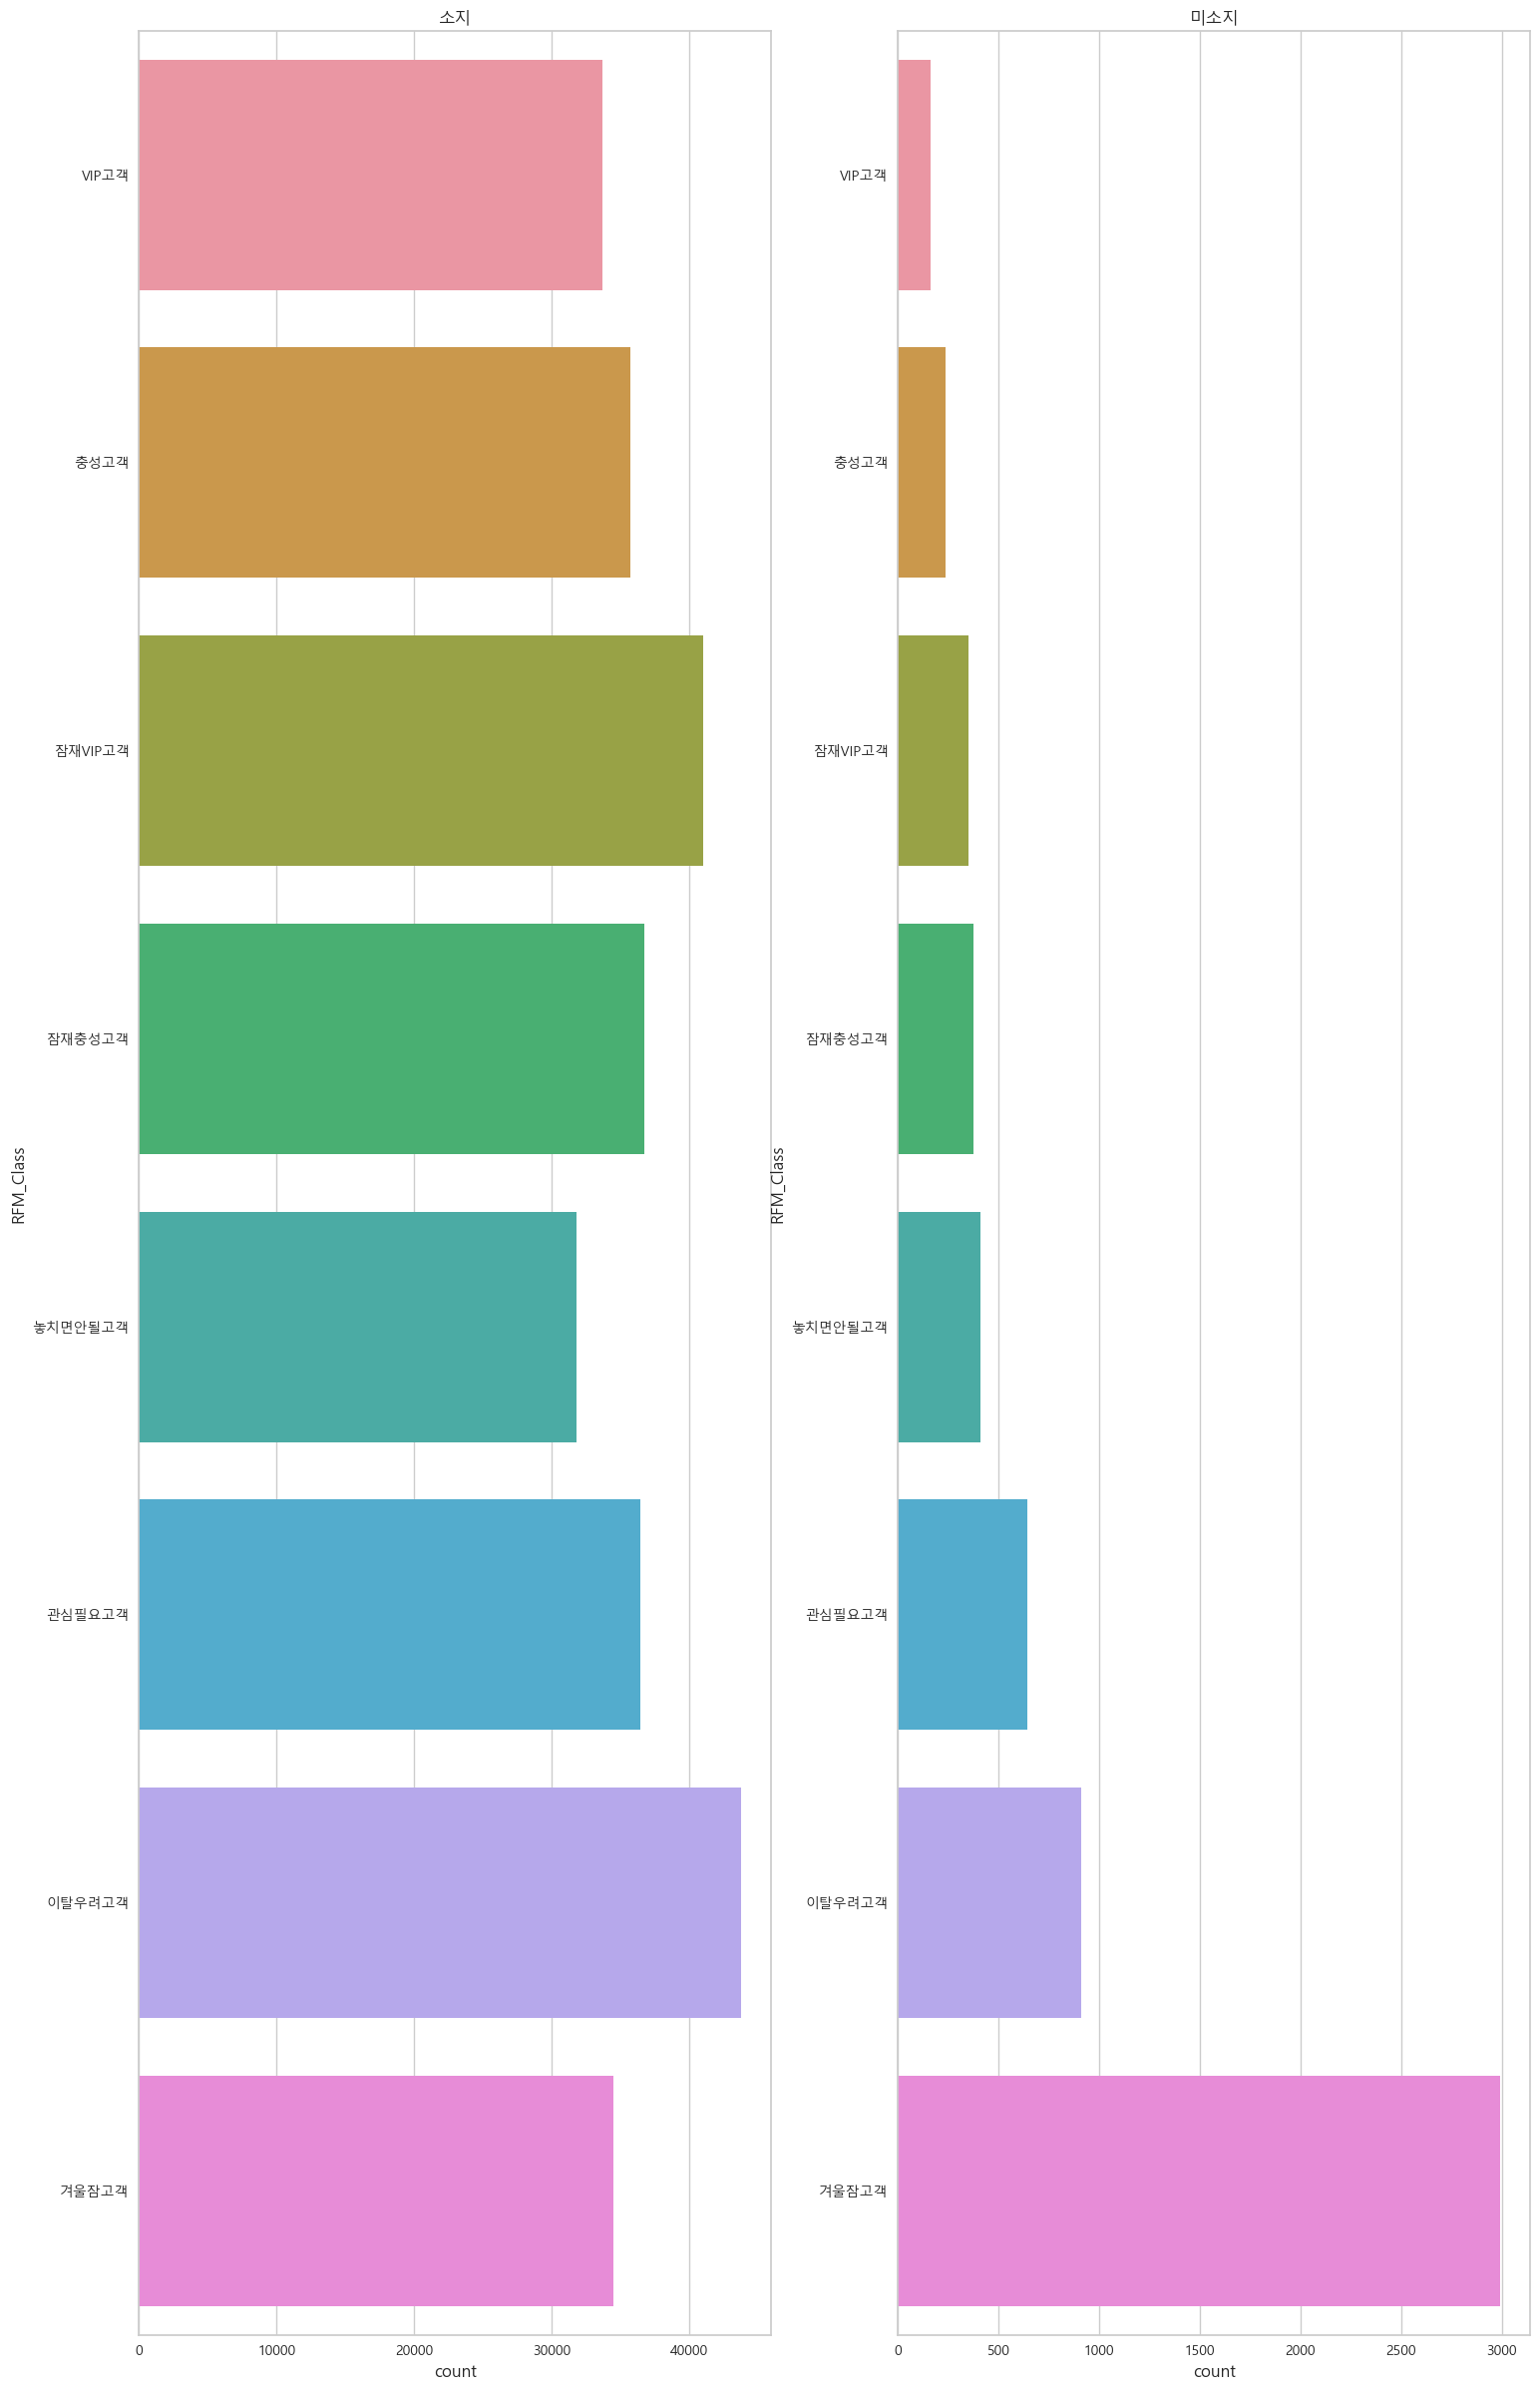

In [274]:
# 소지여부_신용에 따른 RFM_Class의 빈도
fig, axs = plt.subplots(1, 2, figsize = (18, 30))

for i in range(2):
    st = '소지' if i == 0 else '미소지' 
    sns.countplot(y = 'RFM_Class', data = df2[df2['소지여부_신용'] == st], orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']), ax = axs[i])
    axs[i].set_title(st)
plt.show()

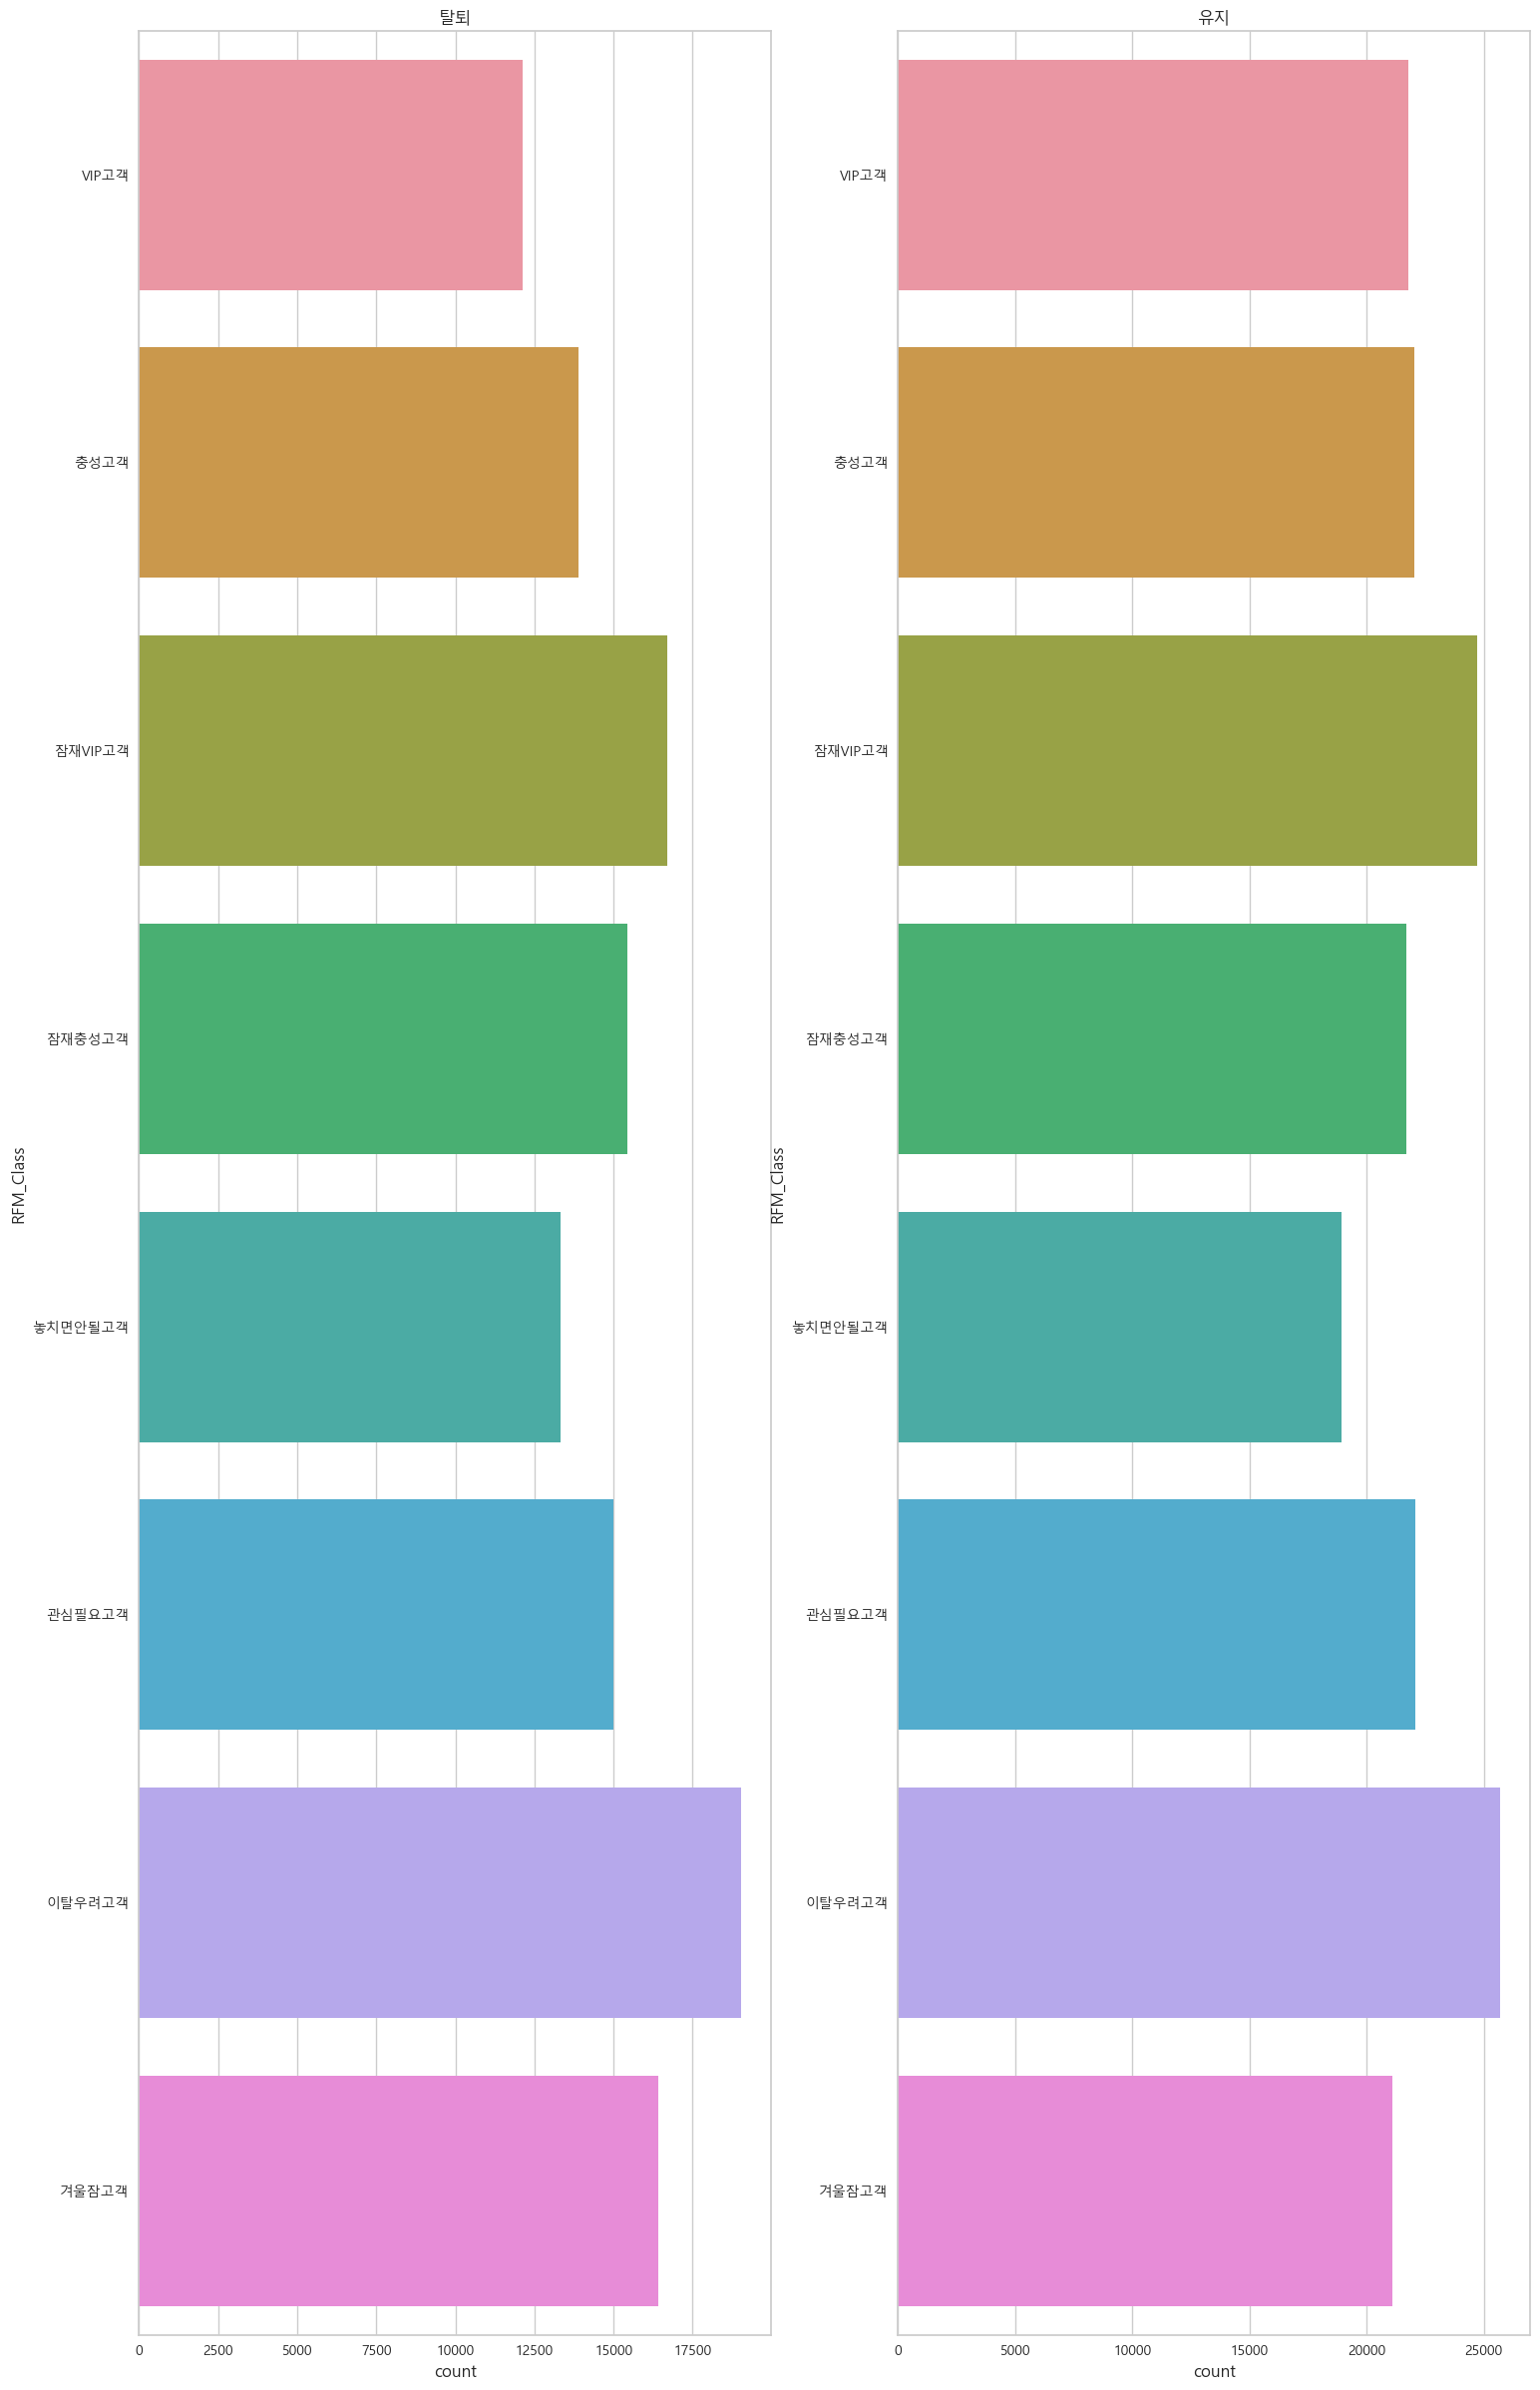

In [276]:
# 탈회여부에 따른 RFM_Class의 빈도
fig, axs = plt.subplots(1, 2, figsize = (18, 30))

for i in range(2):
    st = '탈퇴' if i == 0 else '유지' 
    sns.countplot(y = 'RFM_Class', data = df2[df2['탈회여부'] == st], orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']), ax = axs[i])
    axs[i].set_title(st)
plt.show()

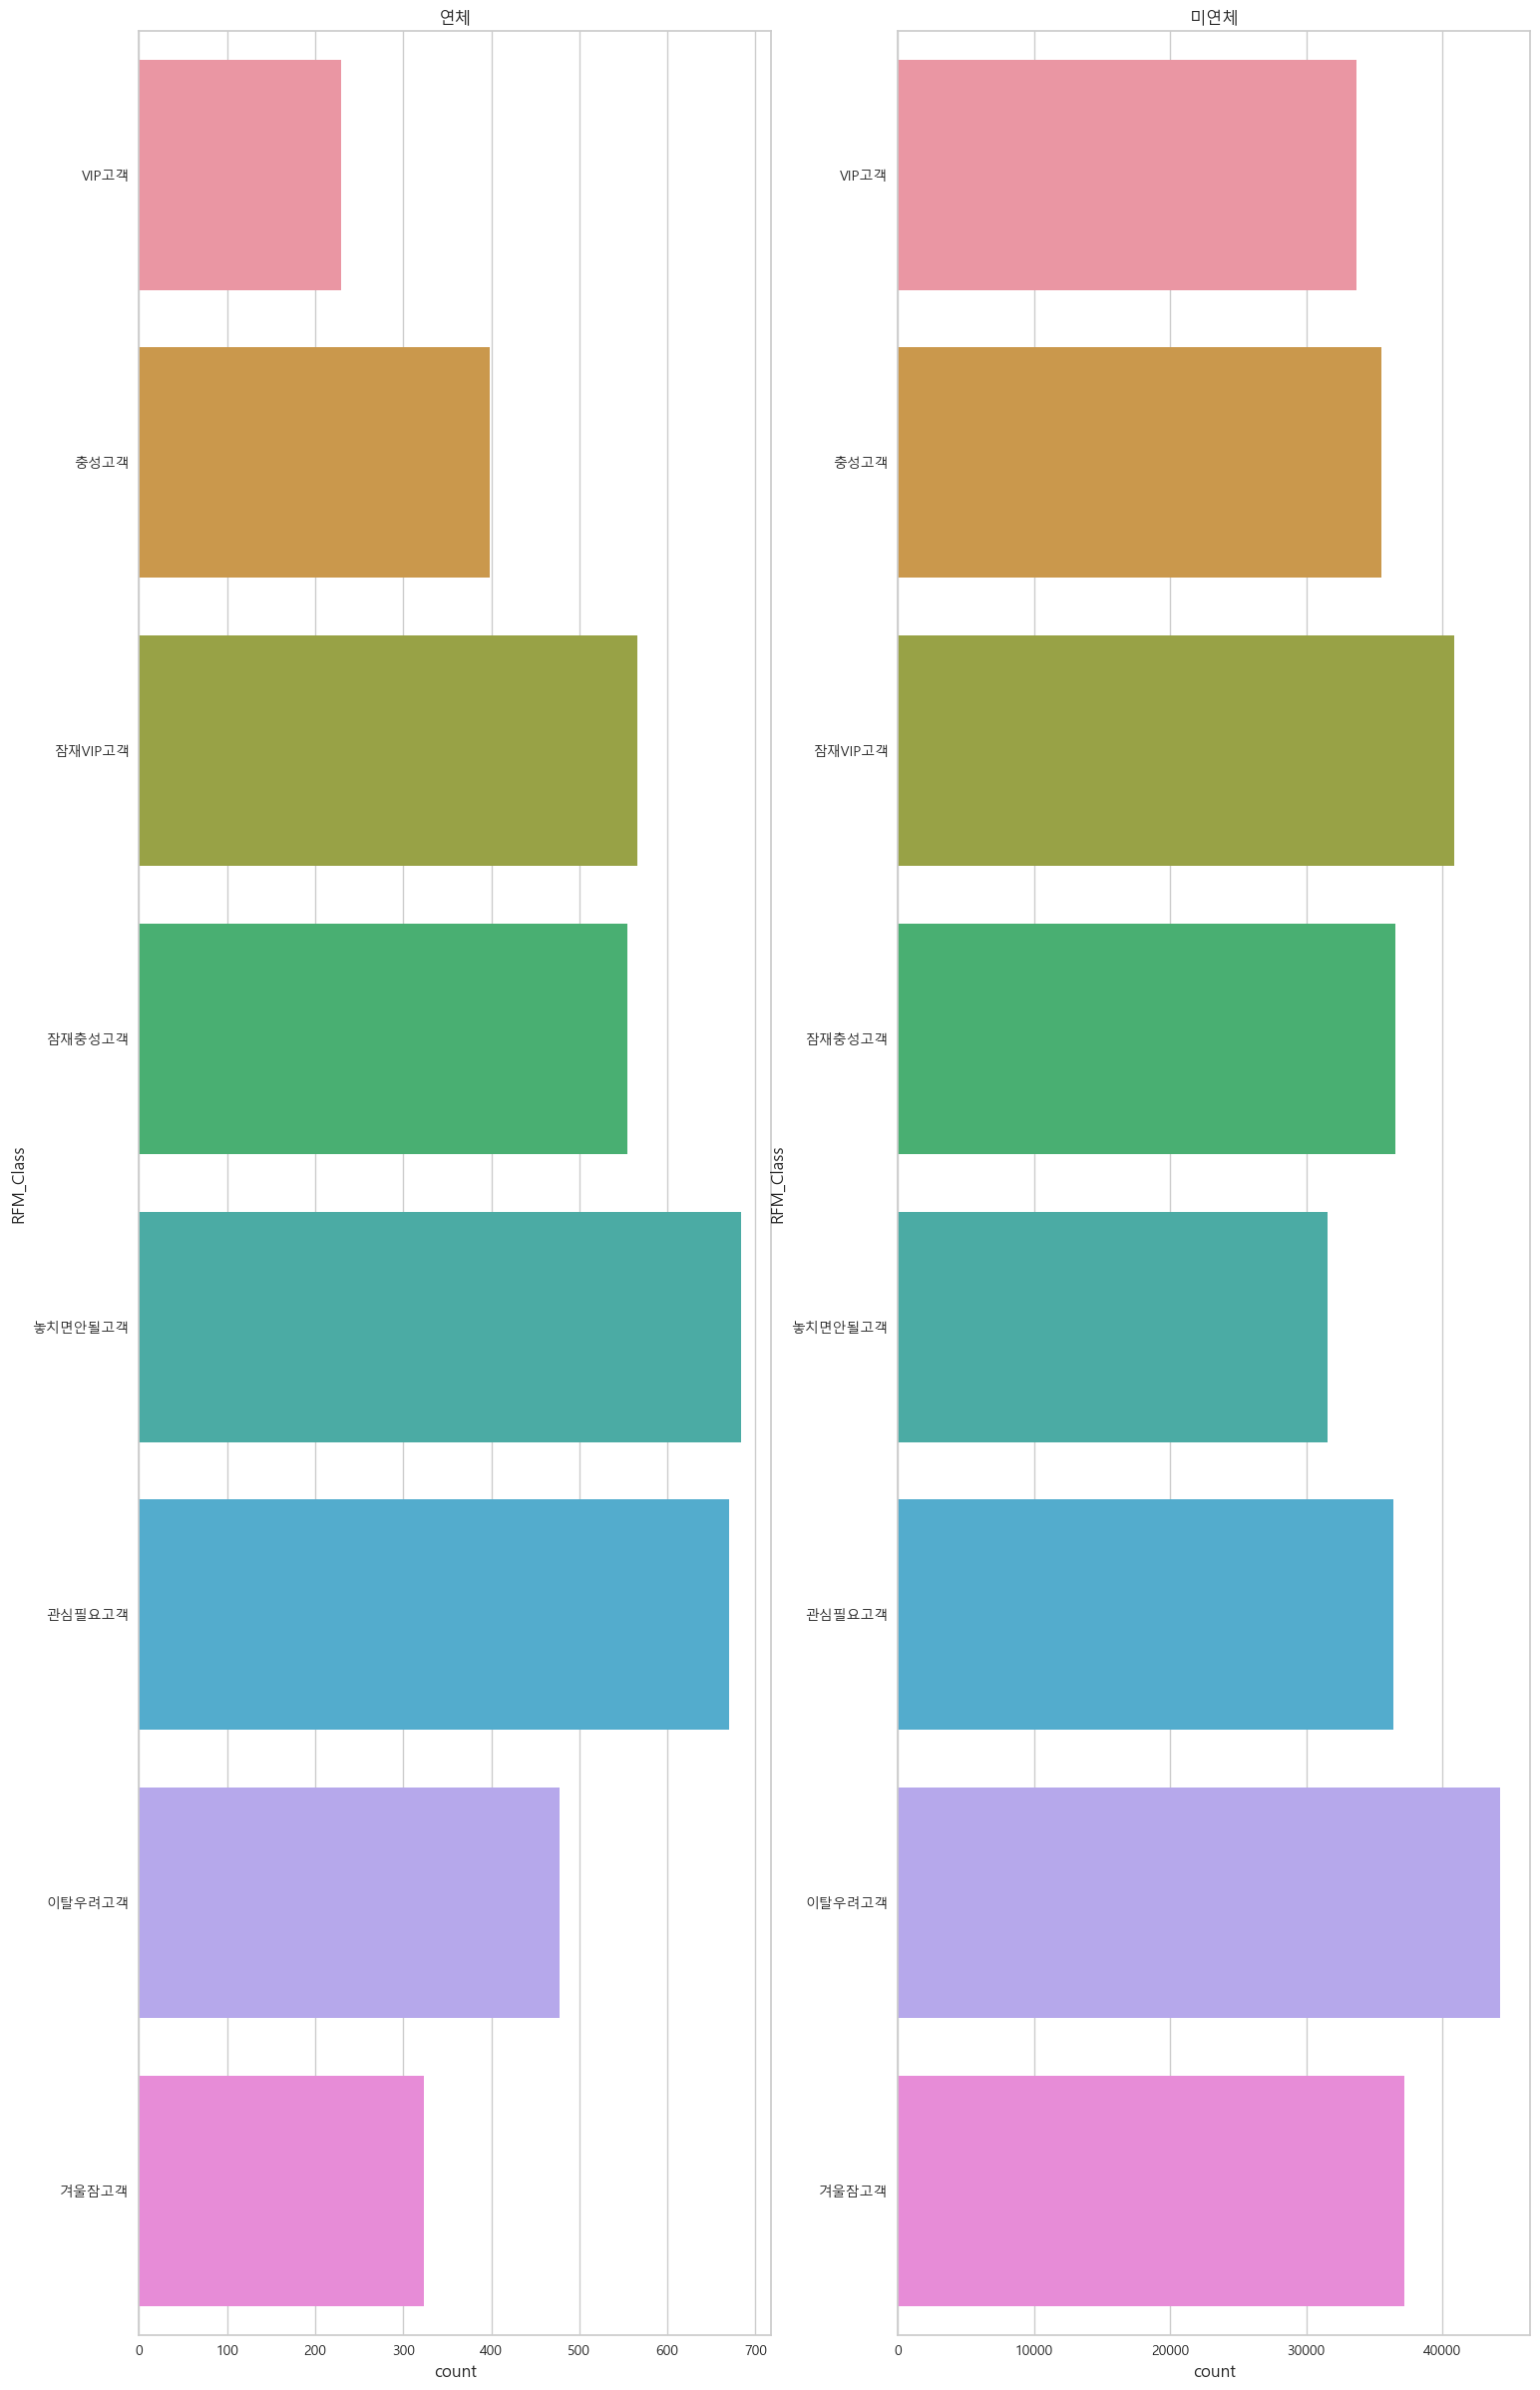

In [277]:
# 회원여부_연체에 따른 RFM_Class의 빈도
fig, axs = plt.subplots(1, 2, figsize = (18, 30))

for i in range(2):
    st = '연체' if i == 0 else '미연체' 
    sns.countplot(y = 'RFM_Class', data = df2[df2['회원여부_연체'] == st], orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']), ax = axs[i])
    axs[i].set_title(st)
plt.show()

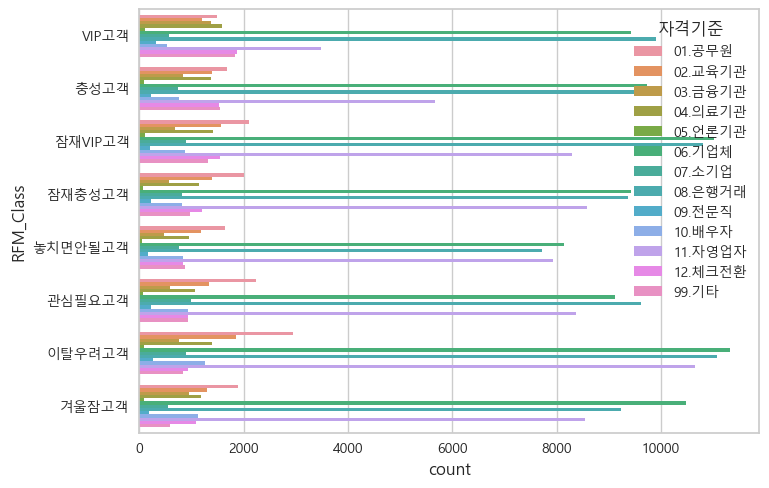

In [280]:
# 회원여부_연체에 따른 RFM_Class의 빈도
sns.countplot(y = 'RFM_Class', data = df2[df2['회원여부_연체'] == st], orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']), hue = '자격기준', hue_order = sorted(df2['자격기준'].unique(), key = lambda x : int(x[:2])))
plt.show()

In [375]:
temp = pd.DataFrame({'RFM' : ['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객']})
temp['Occupation_Max'] = temp['RFM'].map(lambda x : df2.loc[df2['RFM_Class'] == x, '자격구분상세'].mode()[0])
temp['Occupation_Min'] = temp['RFM'].map(lambda x : df2.loc[df2['RFM_Class'] == x, '자격구분상세'].value_counts().index[-1])
temp

,RFM,Occupation_Max,Occupation_Min
0,겨울잠고객,08.은행거래_수신평잔,03.금융기관
1,이탈우려고객,08.은행거래_수신평잔,08.은행거래_하나저축은행거래
2,관심필요고객,08.은행거래_수신평잔,08.은행거래_하나저축은행거래
3,놓치면안될고객,08.은행거래_수신평잔,08.은행거래_하나저축은행거래
4,잠재충성고객,08.은행거래_수신평잔,08.은행거래_하나저축은행거래
5,잠재VIP고객,08.은행거래_수신평잔,08.은행거래_하나저축은행거래
6,충성고객,08.은행거래_수신평잔,08.은행거래_하나대투거래
7,VIP고객,08.은행거래_수신평잔,08.은행거래_하나대투거래


In [376]:
df2['자격구분상세'].value_counts()

08.은행거래_수신평잔                    61493
10.부동산보유                        35972
06.기업체_개인사업체임의단체연소득2.4천이상       24937
99.기타                           23101
06.기업체_납입자본금3억이상중소기업            20110
06.기업체_30대그룹계열사및상장법인            19073
06.기업체_납입자본금3억미만중소기업            13111
07.소기업                          12212
13.체크전환                         10166
01.공무원_일반                        8230
08.은행거래_부동산담보대출                  7925
11.배우자                           7241
01.공무원_정부투자공공기관                  6673
08.은행거래_신용대출                     6179
02.교육기관_초중고교사                    4840
04.의료기관_의료관련면허소시자                4113
04.의료기관                          3207
00.SK제휴사                         3099
14.사업소득                          3052
04.의료기관_의사약사한의사                  2895
03.금융기관_은행증권보험은행연합회              2662
06.기업체_코스닥등록기업                   2043
08.은행거래_급여이체                     2019
02.교육기관_유치원어린이집                  1869
00.하나카드및관계사                      1544
02.교육기관_학교법인직원                   1532
02.교육기관_대학교교

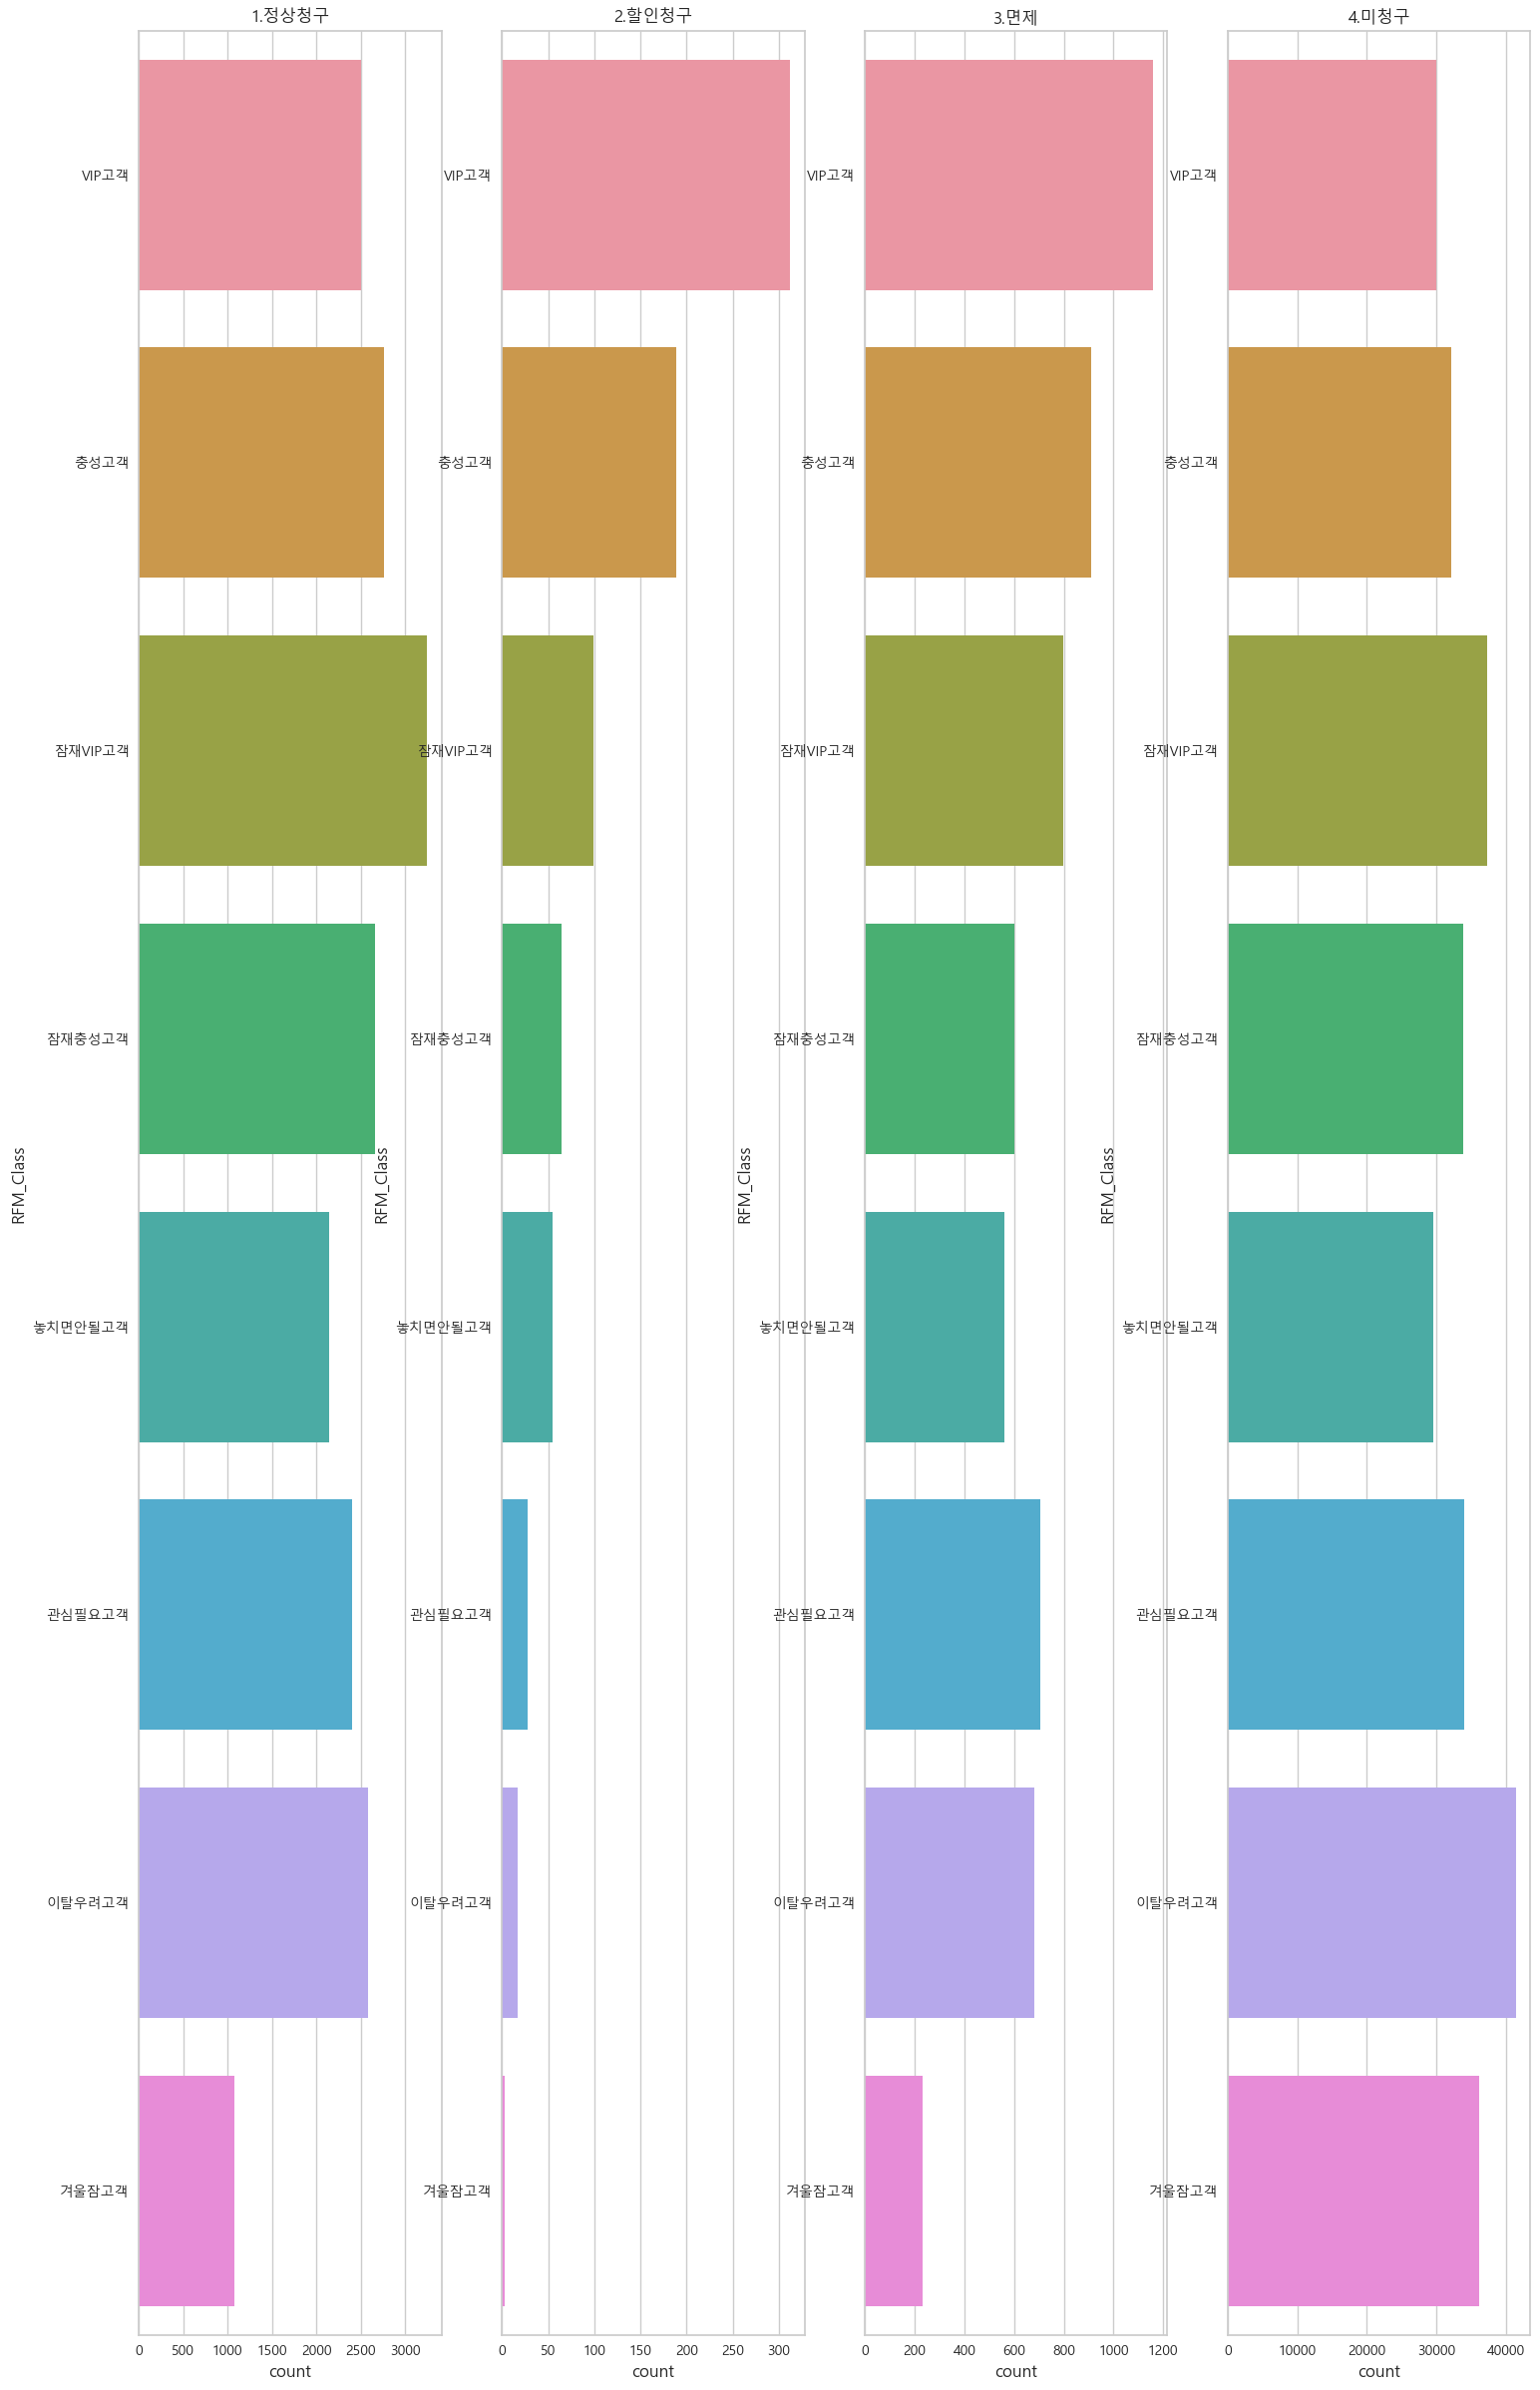

In [313]:
# 연회비청구구분_B0M에 따른 RFM_Class의 빈도
fig, axs = plt.subplots(1, 4, figsize = (18, 30))

for i in range(4):
    if i == 0:
        st = '1.정상청구'
    elif i == 1:
        st = '2.할인청구'
    elif i == 2:
        st = '3.면제'
    else:
        st = '4.미청구'
    sns.countplot(y = 'RFM_Class', data = df2[df2['연회비청구구분_B0M'] == st], orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']), ax = axs[i])
    axs[i].set_title(st)
plt.show()

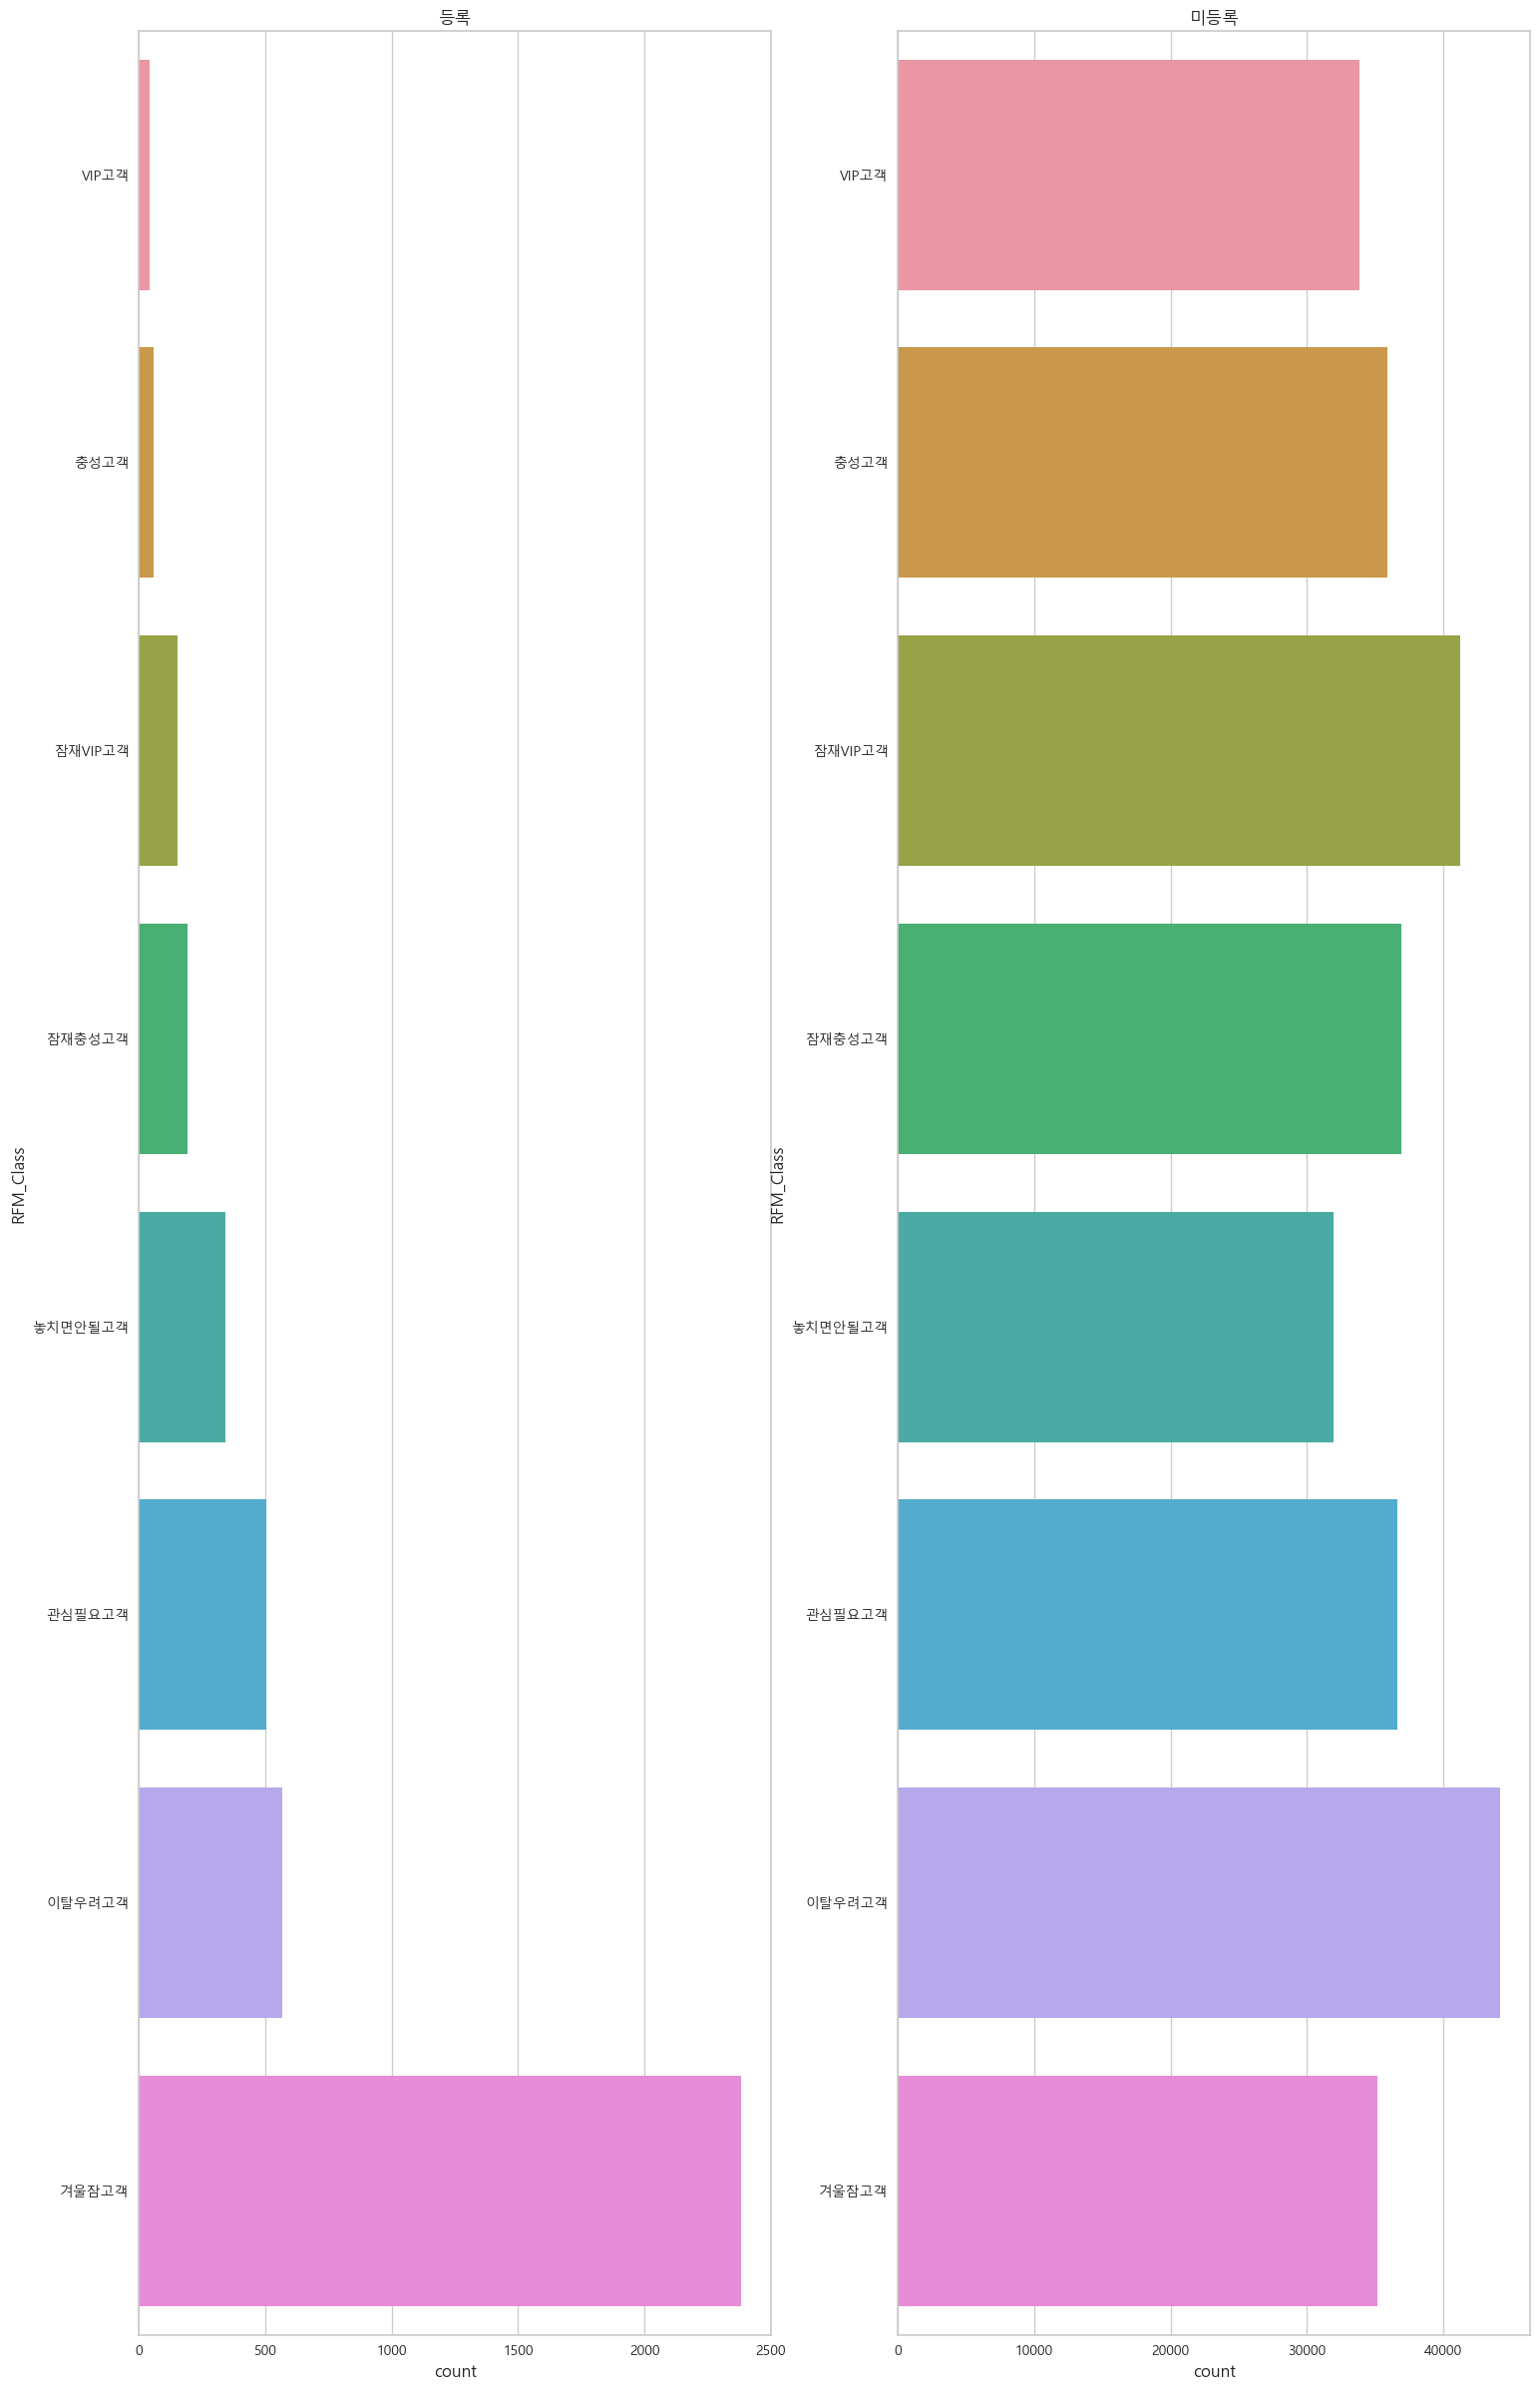

In [314]:
# BL여부_R12M에 따른 RFM_Class의 빈도
fig, axs = plt.subplots(1, 2, figsize = (18, 30))

for i in range(2):
    st = '등록' if i == 0 else '미등록' 
    sns.countplot(y = 'RFM_Class', data = df2[df2['BL여부_R12M'] == st], orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']), ax = axs[i])
    axs[i].set_title(st)
plt.show()

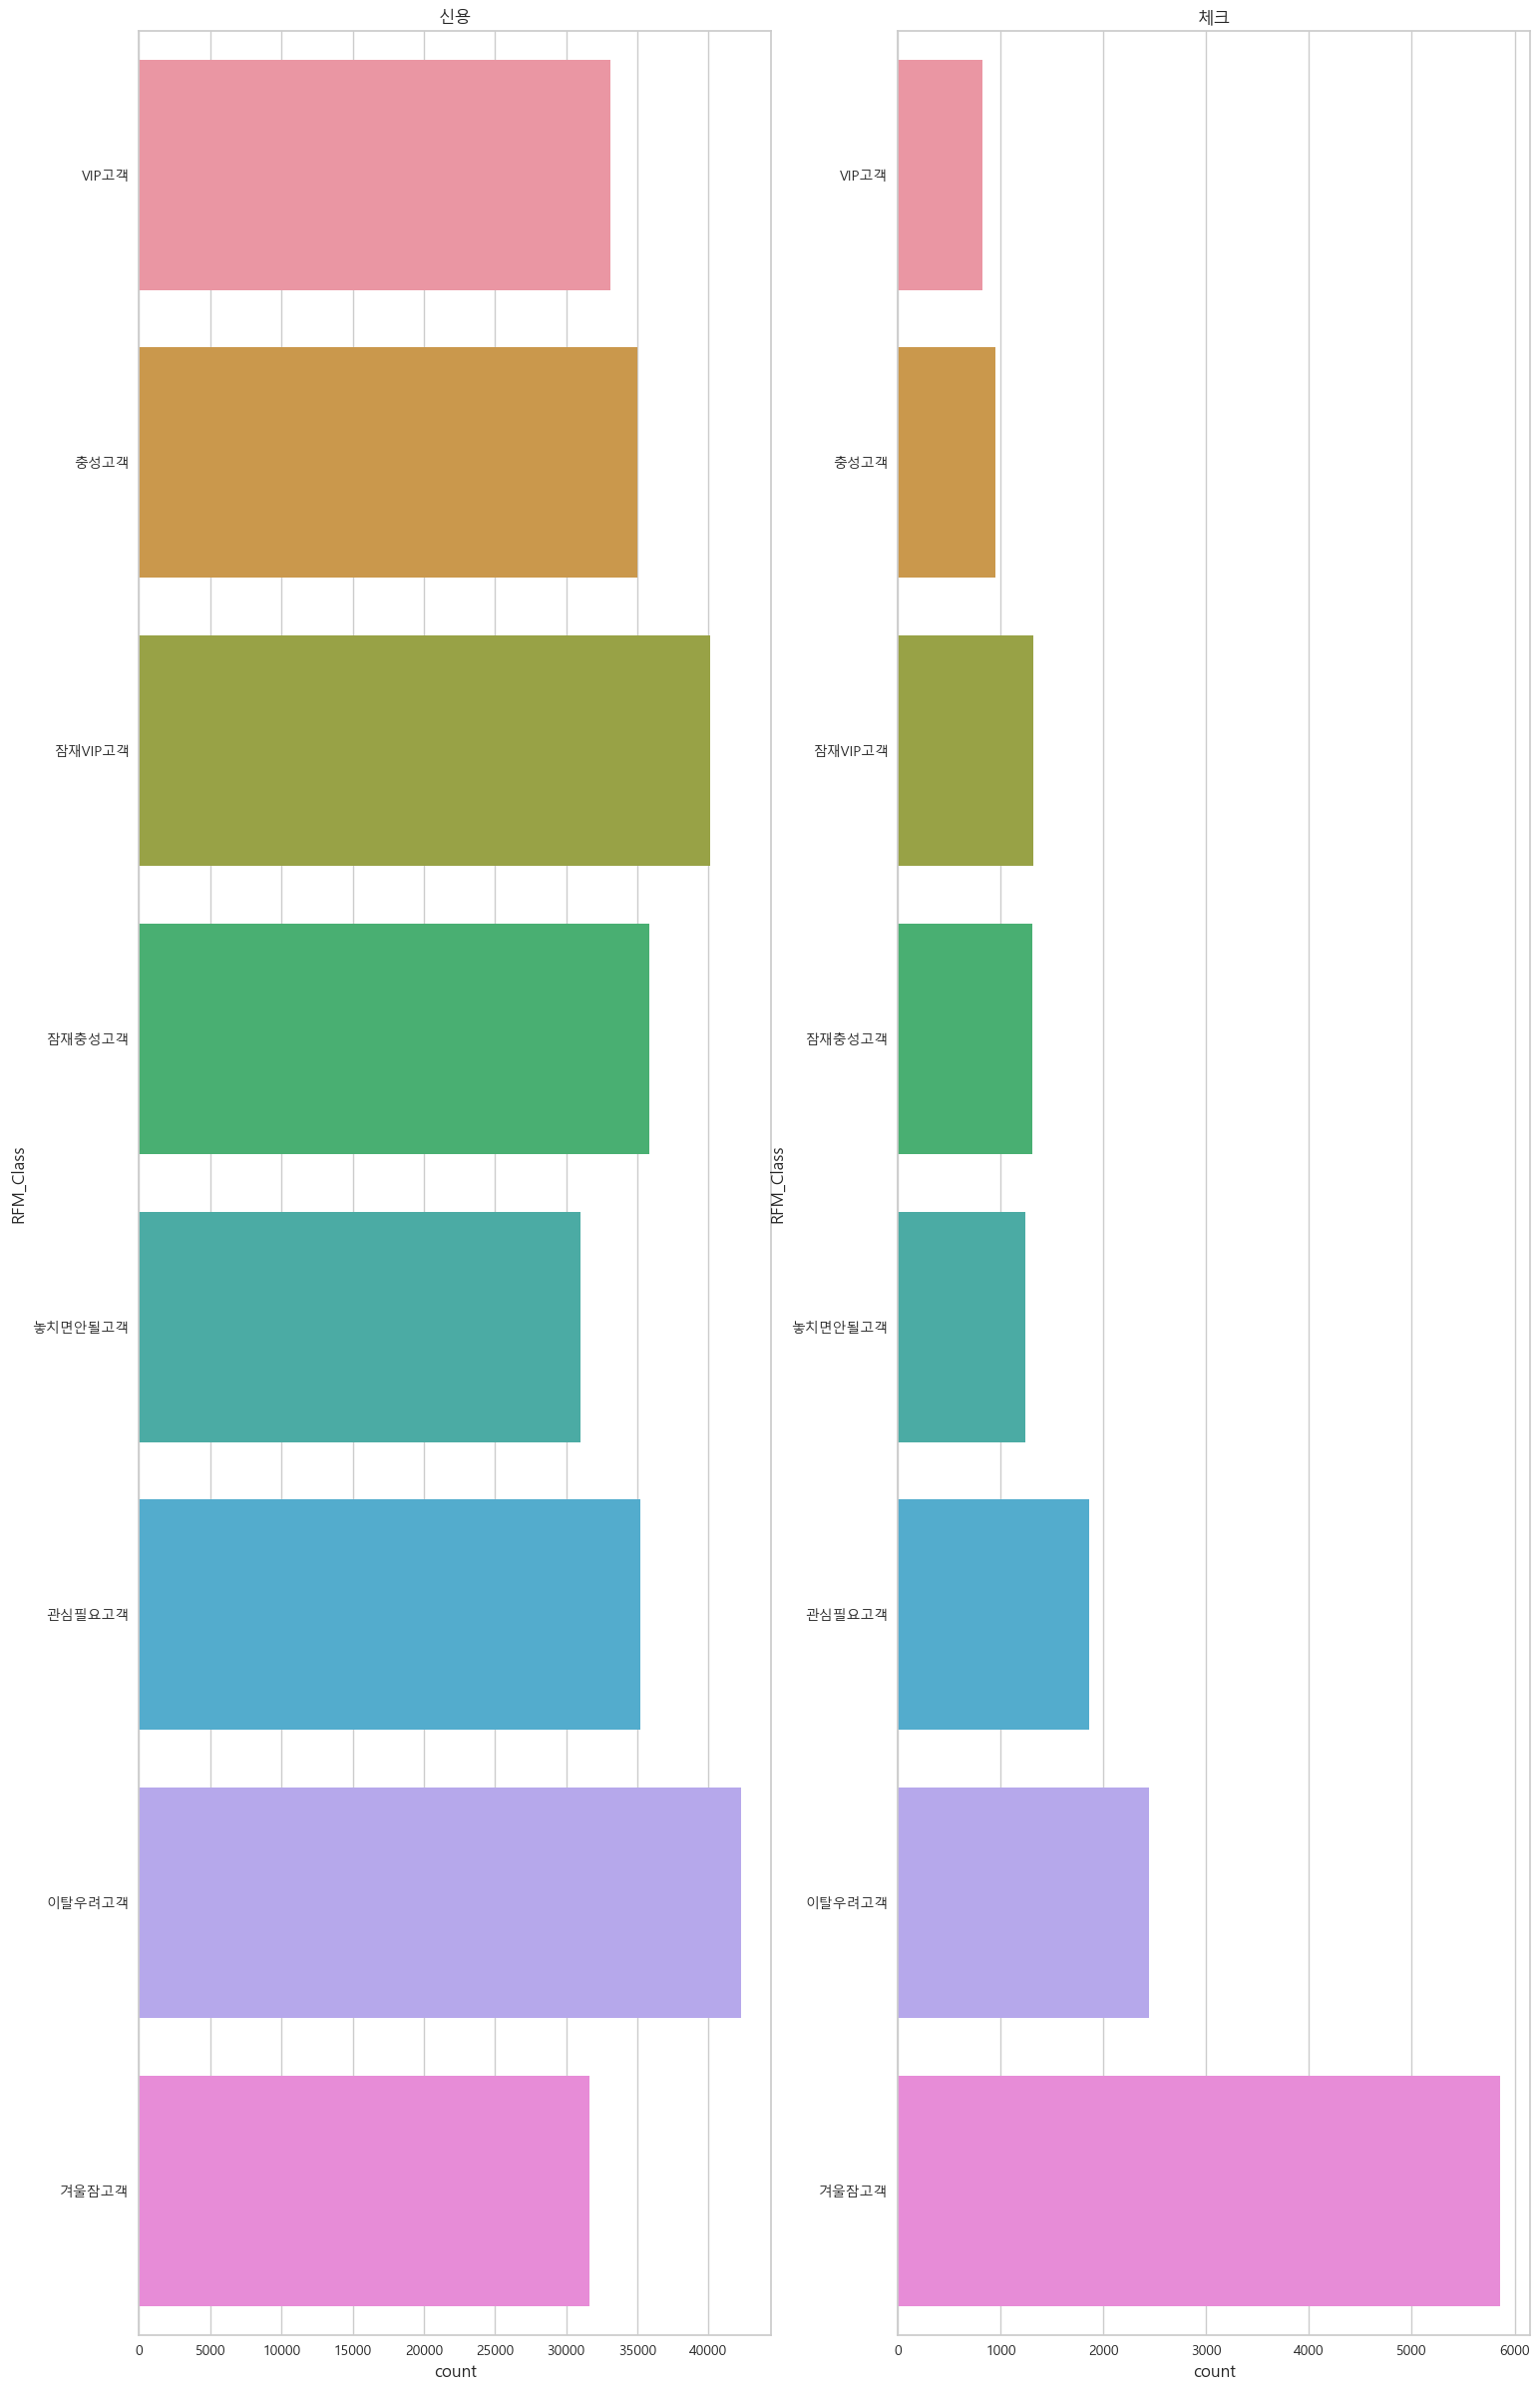

In [315]:
# _1순위신용체크구분에 따른 RFM_Class의 빈도
fig, axs = plt.subplots(1, 2, figsize = (18, 30))

for i in range(2):
    st = '신용' if i == 0 else '체크' 
    sns.countplot(y = 'RFM_Class', data = df2[df2['_1순위신용체크구분'] == st], orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']), ax = axs[i])
    axs[i].set_title(st)
plt.show()

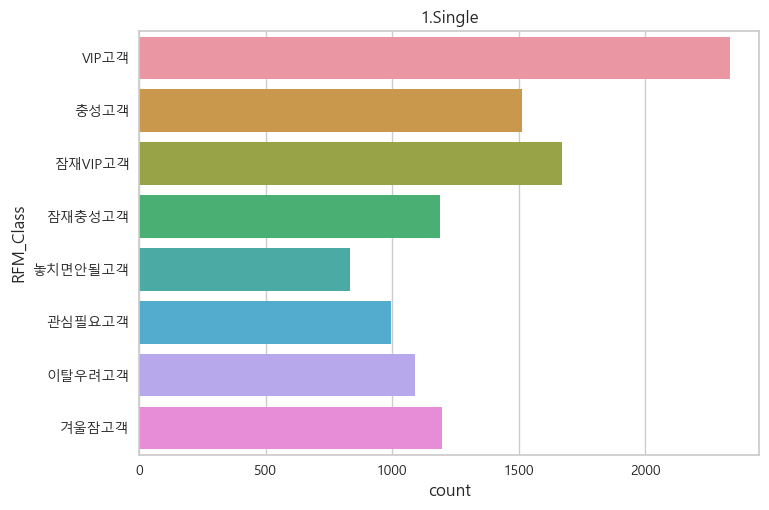

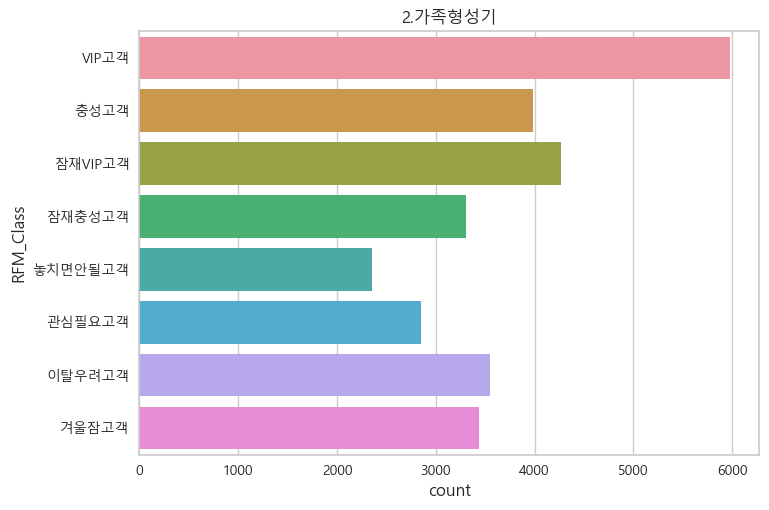

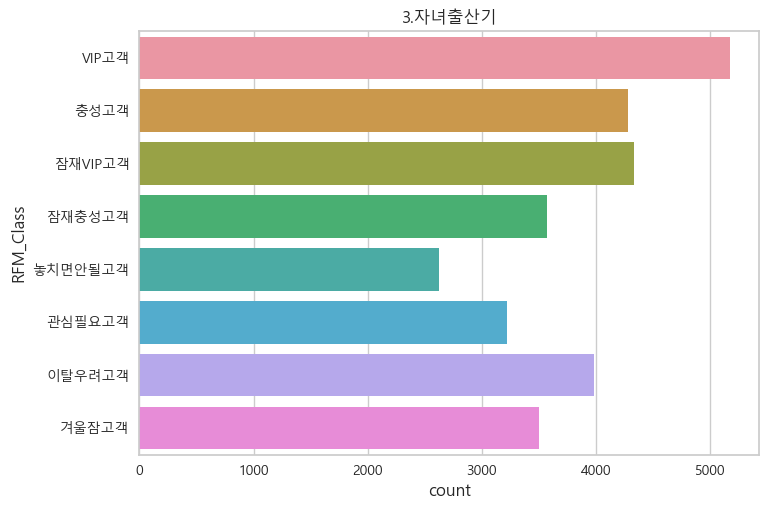

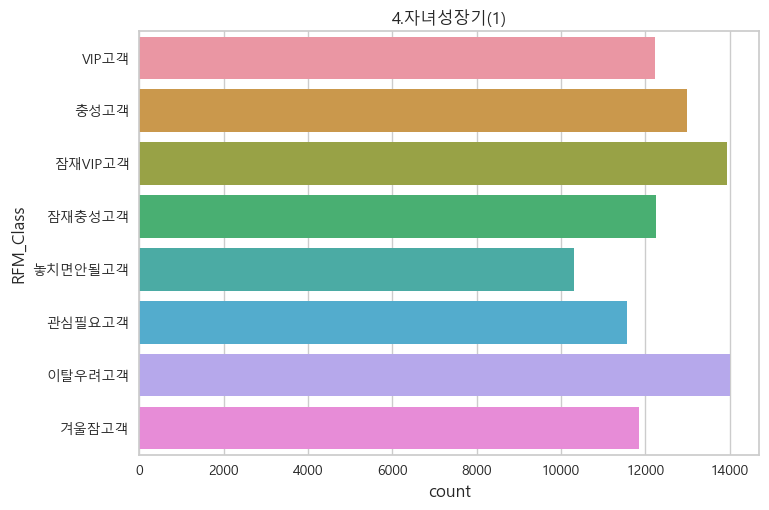

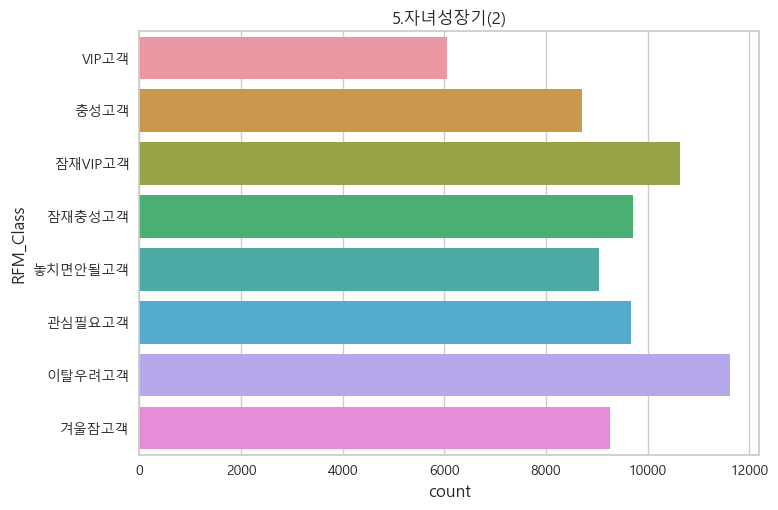

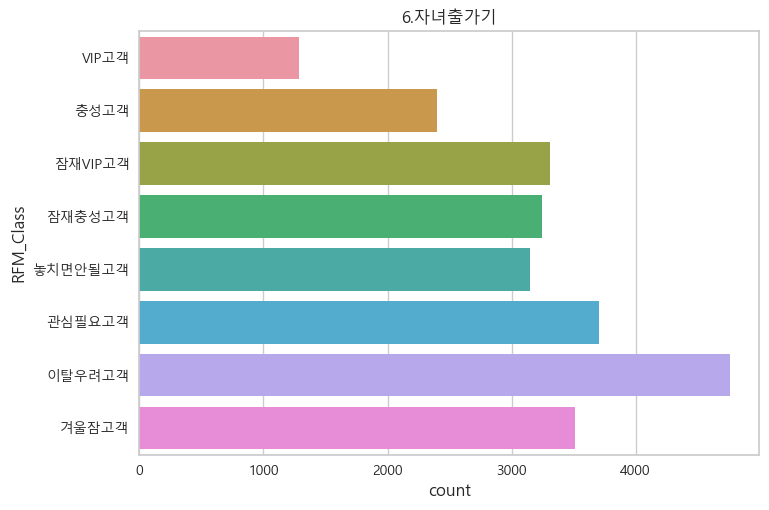

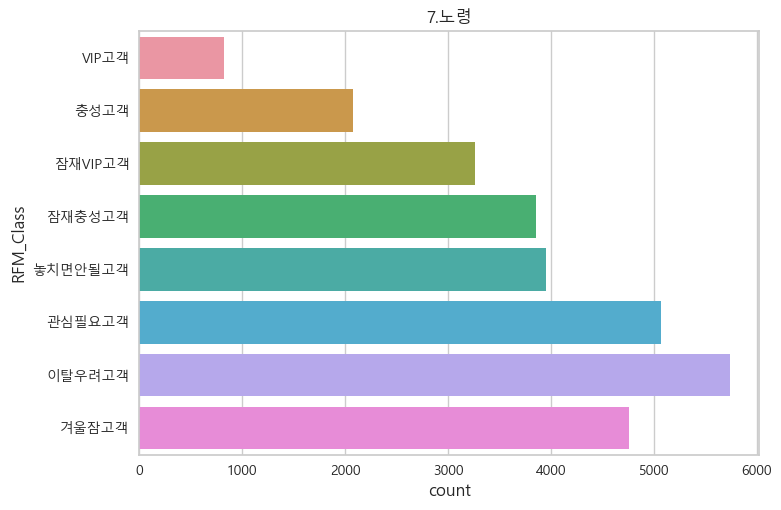

In [324]:
# Life_Stage에 따른 RFM_Class의 빈도

for i in range(7):
    if i == 0:
        st = '1.Single'
    elif i == 1:
        st = '2.가족형성기'
    elif i == 2:
        st = '3.자녀출산기'
    elif i == 3 :
        st = '4.자녀성장기(1)'
    elif i == 4:
        st = '5.자녀성장기(2)'
    elif i == 5:
        st = '6.자녀출가기'
    else:
        st = '7.노령'
    sns.countplot(y = 'RFM_Class', data = df2[df2['Life_Stage'] == st], orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']))
    plt.title(st)
    plt.show()

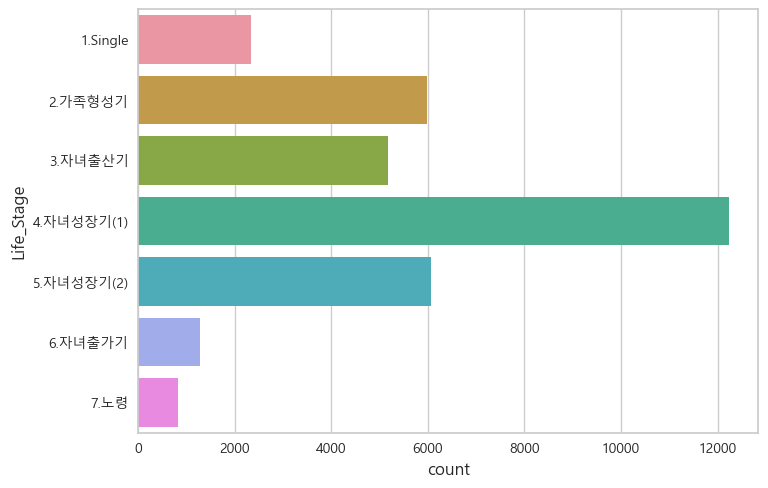

In [372]:
sns.countplot(y = 'Life_Stage', data = df2[df2['RFM_Class'] == 'VIP고객'], orient = 'h', order = ['1.Single', '2.가족형성기', '3.자녀출산기', '4.자녀성장기(1)', '5.자녀성장기(2)', '6.자녀출가기', '7.노령'])
plt.show()

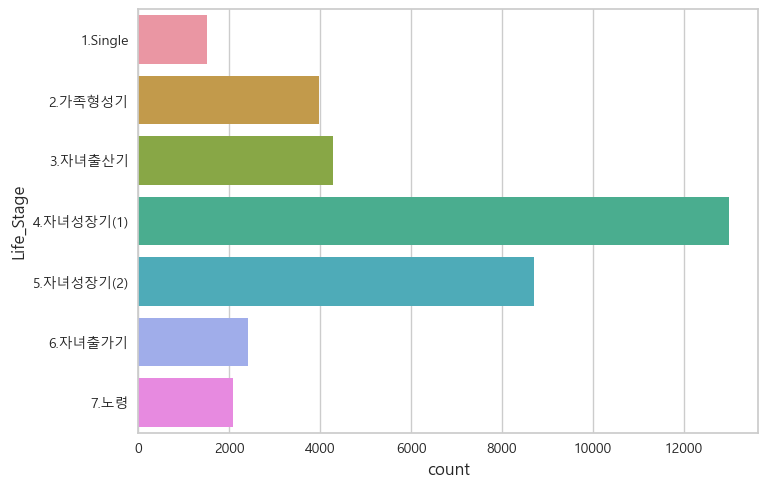

In [374]:
sns.countplot(y = 'Life_Stage', data = df2[df2['RFM_Class'] == '충성고객'], orient = 'h', order = ['1.Single', '2.가족형성기', '3.자녀출산기', '4.자녀성장기(1)', '5.자녀성장기(2)', '6.자녀출가기', '7.노령'])
plt.show()

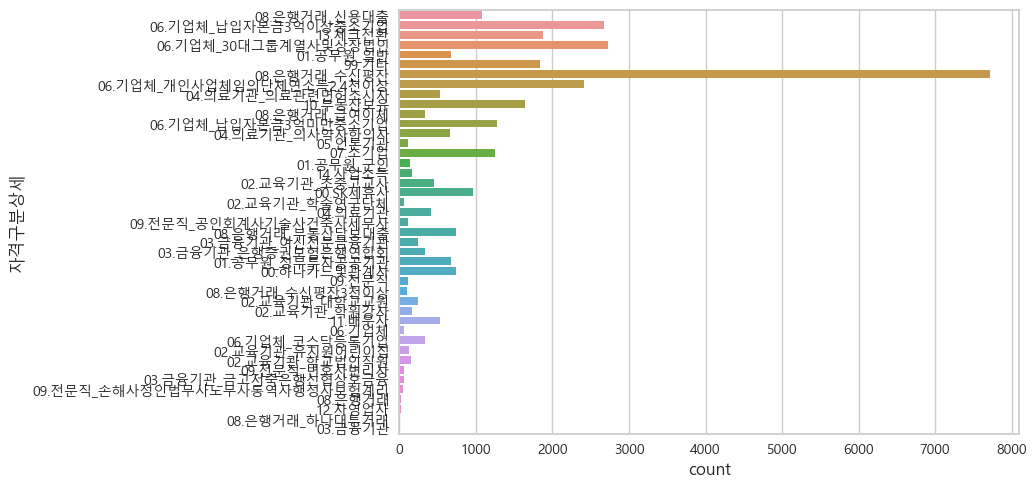

In [380]:
sns.countplot(y = '자격구분상세', data = df2[df2['RFM_Class'] == 'VIP고객'], orient = 'h')
plt.show()

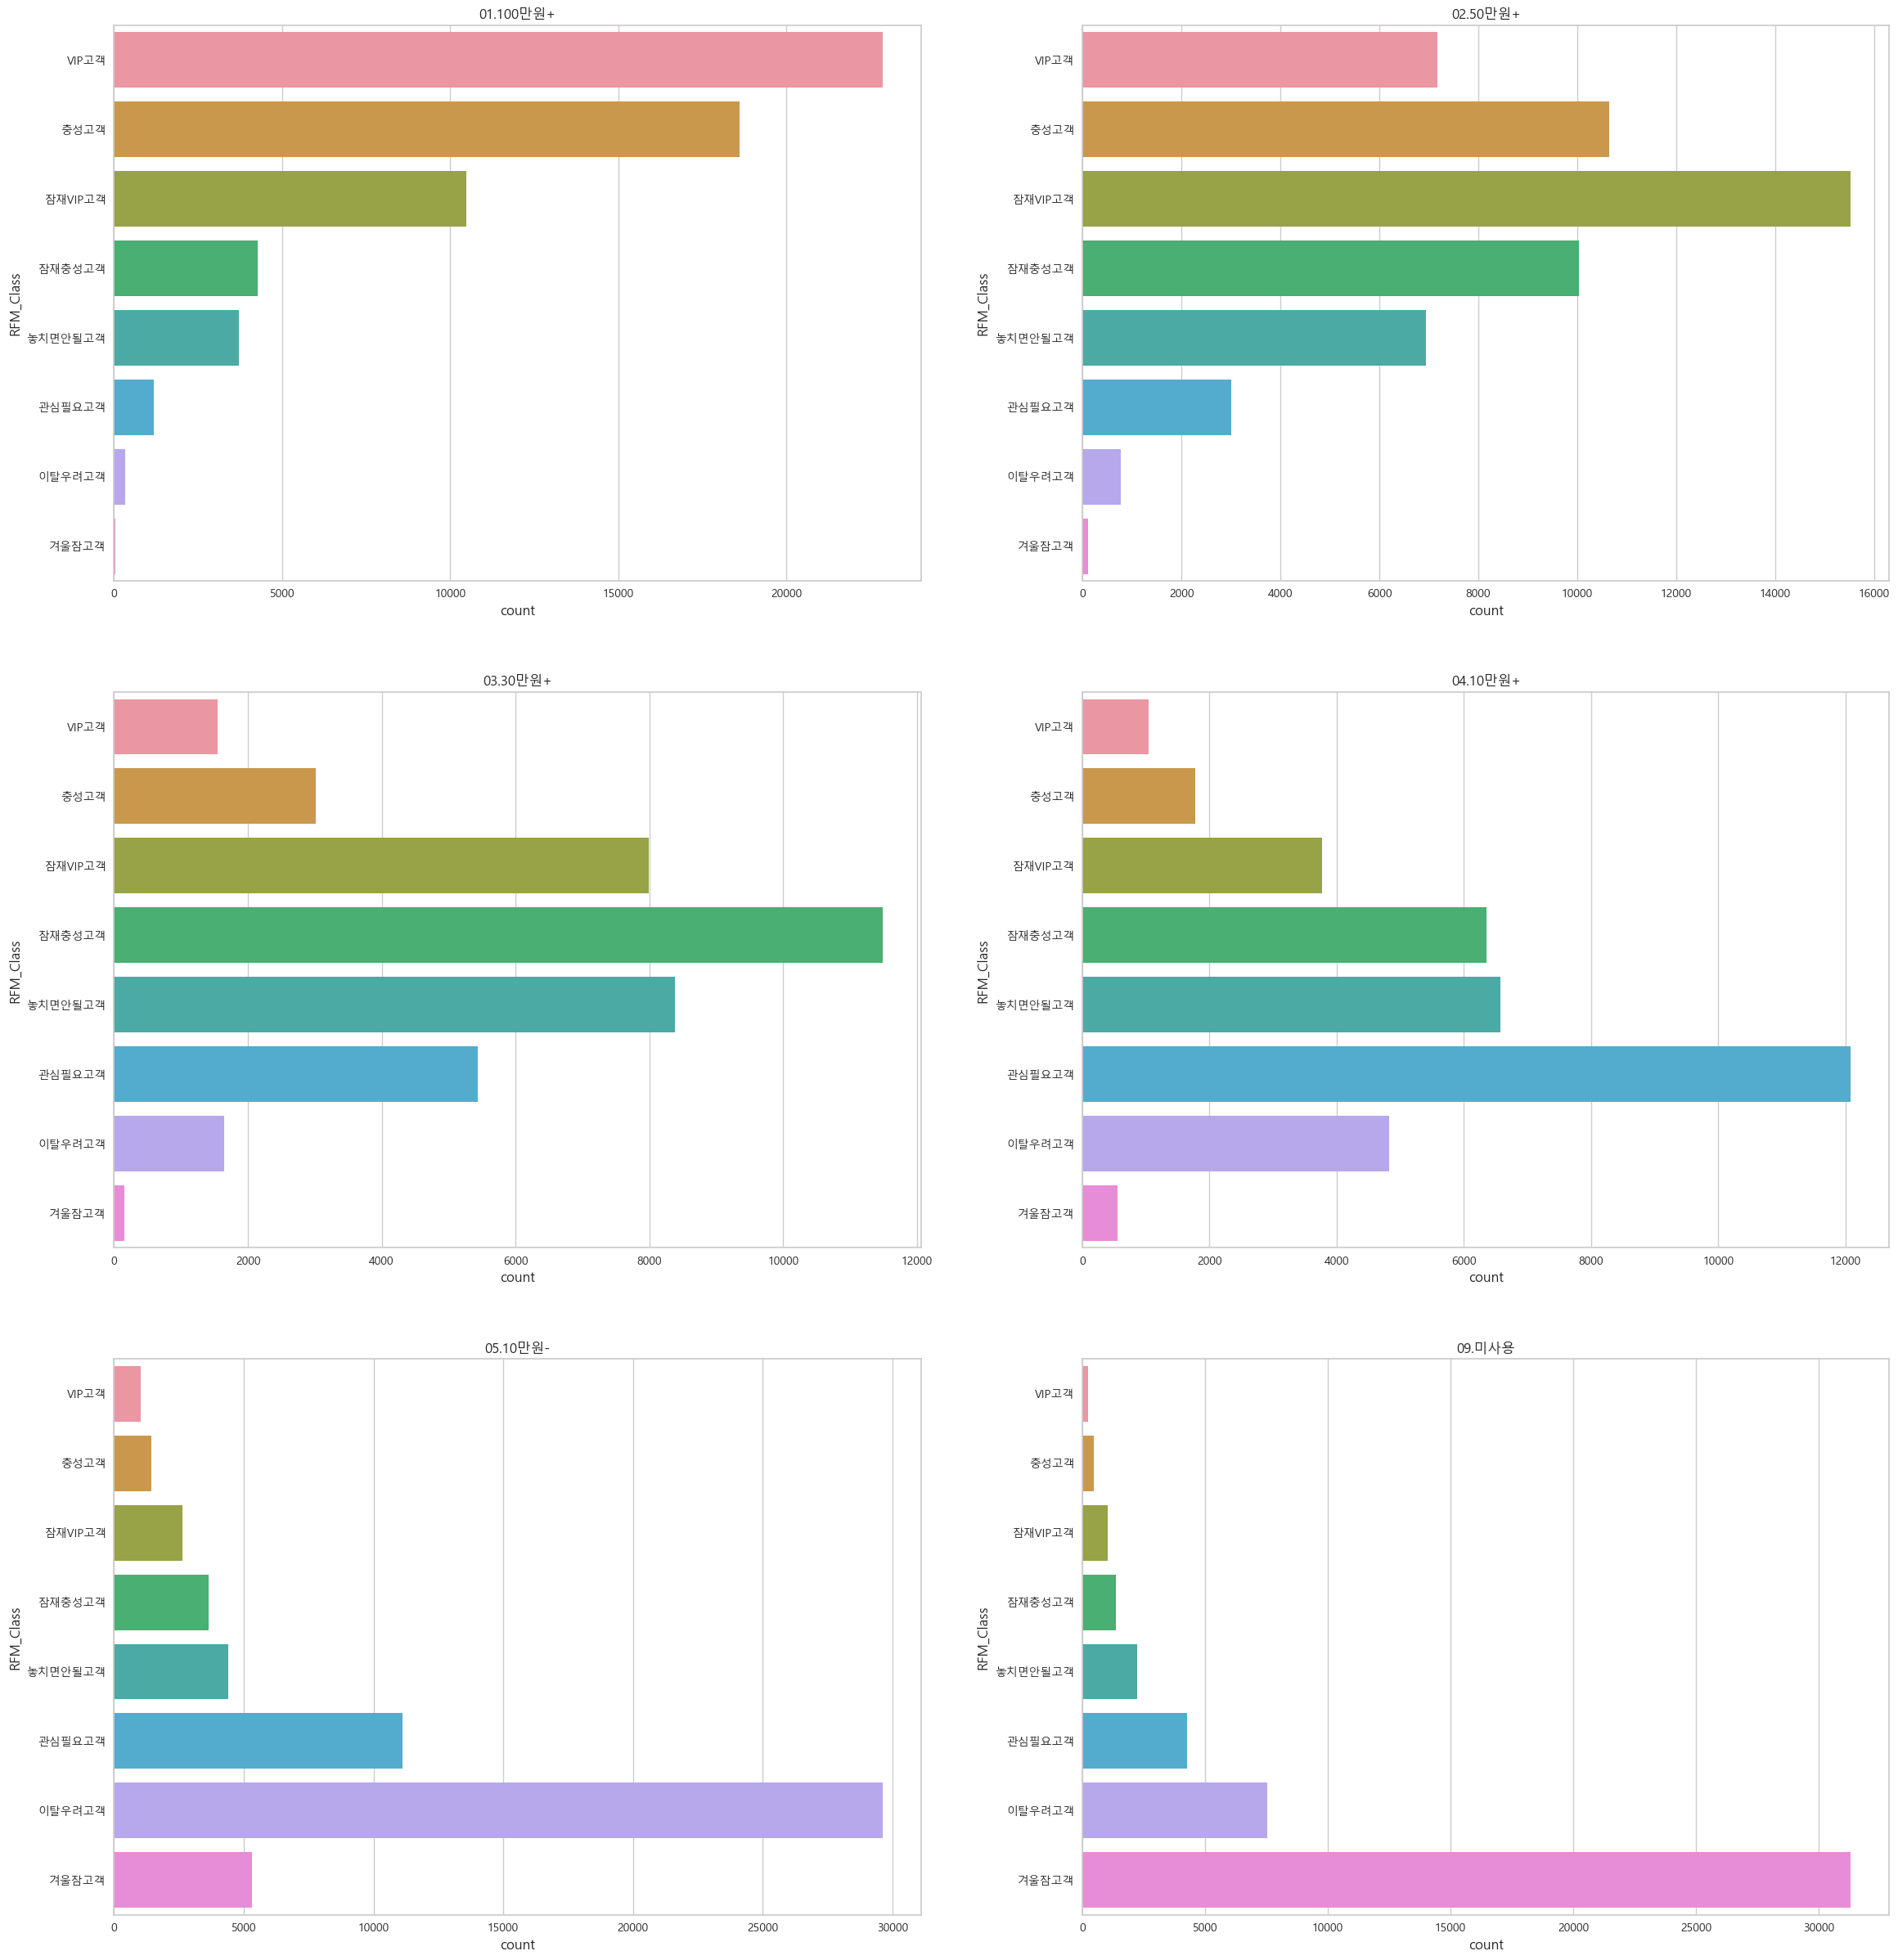

In [327]:
# 이용금액대에 따른 RFM_Class의 빈도
df_val = ['01.100만원+', '02.50만원+', '03.30만원+', '04.10만원+', '05.10만원-','09.미사용']
cnt = 0
fig, axs = plt.subplots(3, 2, figsize = (28, 30))

for i in range(3):
  for j in range(2):
      sns.countplot(y = 'RFM_Class', data = df2[df2['이용금액대'] == df_val[cnt]], orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']), ax = axs[i, j])
      axs[i, j].set_title(f'{df_val[cnt]}')
      cnt += 1
plt.show()

# AutoML

In [332]:
!pip install pycaret

In [382]:
from pycaret.classification import *

# 1. 데이터 준비
setup_clf = setup(data=df2.loc[(df2['고객구분_New'].isin(['연속', '휴면'])), df2.columns[(df2.dtypes == np.int64) | (df2.dtypes == np.float64) | (df2.columns == '고객구분_New')]], target='고객구분_New', train_size=0.8,
                  normalize=True, normalize_method='zscore', feature_selection = True, feature_selection_method = 'classic',
                  n_features_to_select = 0.1, session_id=777,n_jobs=-1)
# 2. 모델 비교
model = compare_models(sort='Accuracy', fold = 5, n_select=10)
print(model)

,Description,Value
0,Session id,777
1,Target,고객구분_New
2,Target type,Binary
3,Target mapping,"연속: 0, 휴면: 1"
4,Original data shape,"(230610, 275)"
5,Transformed data shape,"(230610, 28)"
6,Transformed train set shape,"(184488, 28)"
7,Transformed test set shape,"(46122, 28)"
8,Numeric features,274
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.3340
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1640
ridge,Ridge Classifier,1.0000,0.0000,1.0000,0.9999,1.0000,0.9999,0.9999,1.1720
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.2820
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1320
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0580
lda,Linear Discriminant Analysis,1.0000,1.0000,1.0000,0.9999,1.0000,0.9999,0.9999,1.1280
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.3020
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.3900
svm,SVM - Linear Kernel,0.9999,0.0000,0.9999,1.0000,0.9999,0.9998,0.9998,1.1540


Processing:   0%|          | 0/70 [00:00<?, ?it/s]

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=777, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=777, splitter='best'), RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=777, solver='auto',
                tol=0.0001), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=Non

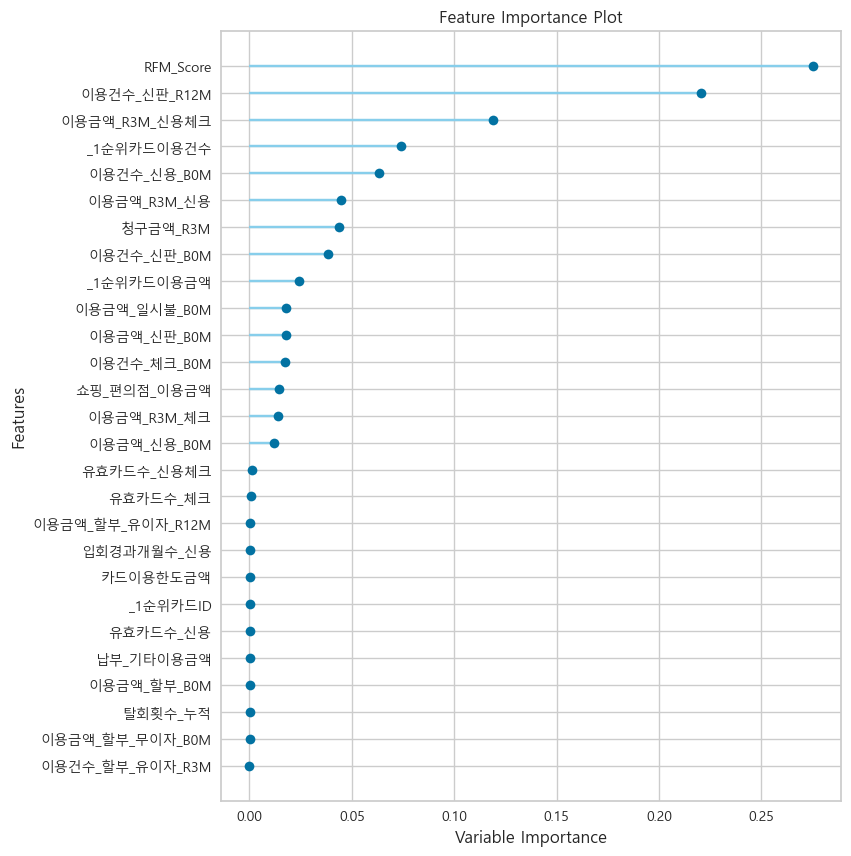

In [383]:
plot_model(model[3], plot='feature_all')